### **Latent Dirichlet Allocation**

In this workbook, we will employ LDA on text data to discover the topics discussed:
- xxx
- xxx
- xxx

In [17]:
# nltk.download('punkt')
# nltk.download('stopwords')

In [23]:
# pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import textblob
import gensim
import tqdm
import textwrap
from PIL import Image

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator

In [2]:
df_processed = pd.read_excel("amazon_review_processed_full.xlsx")
df_processed.head(5)

Review Model Retailer Review date      Review name  \
0     Canon Pixma TS6420a   Amazon  2023-08-10  Ernest Birkholz   
1  HP OfficeJet Pro 9015e   Amazon  2022-06-04           mattey   
2      Canon PIXMA MG3620   Amazon  2023-03-15          Maria D   
3         Epson - ET-3830   Amazon  2022-11-17           Ryan H   
4           HP ENVY 6055e   Amazon  2022-04-09              Sam   

   Review rating       Review title  \
0              5         work great   
1              3    spunki mid size   
2              4                NaN   
3              5  shag know he talk   
4              3      user friendli   

                                      Review Content  \
0                             easi instal work great   
1  slower speed im use old model 8600 new 9015e s...   
2                                                  i   
3  yup slam upgrad paid littl front equival throw...   
4  would think someth simpl reconnect wifi would ...   

   Verified Purchase or not  People_find_helpful  vine or not  ...  \
0                      True                    0        False  ...   
1                      True                    0        False  ...   
2                      True                    0        False  ...   
3                      True                   12        False  ...   
4                      True                    0        False  ...   

  content_stopwords  title_stopwords  Brand  \
0                 3                0  Canon   
1                19                0     HP   
2                 0                0  Canon   
3                31                2  Epson   
4                71                0     HP   

                                         Full review ID    Topic0    Topic1  \
0                  work great easi instal work great  1  0.192308  0.192344   
1  spunki mid size slower speed im use old model ...  2  0.219016  0.111844   
2                                                  i  3  0.200007  0.199993   
3  shag know he talk yup slam upgrad paid littl f...  4  0.168985  0.165481   
4  user friendli would think someth simpl reconne...  5  0.261938  0.203476   

     Topic2    Topic3    Topic4  
0  0.192308  0.230732  0.192308  
1  0.293459  0.163706  0.211975  
2  0.200005  0.200003  0.199992  
3  0.239302  0.162820  0.263412  
4  0.118563  0.275790  0.140233  

[5 rows x 32 columns]

In [3]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10209 entries, 0 to 10208
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Review Model              10209 non-null  object        
 1   Retailer                  10209 non-null  object        
 2   Review date               10209 non-null  datetime64[ns]
 3   Review name               10152 non-null  object        
 4   Review rating             10209 non-null  int64         
 5   Review title              10018 non-null  object        
 6   Review Content            10200 non-null  object        
 7   Verified Purchase or not  10209 non-null  bool          
 8   People_find_helpful       10209 non-null  float64       
 9   vine or not               10209 non-null  bool          
 10  URL                       10209 non-null  object        
 11  list price                10209 non-null  float64       
 12  rating count      

#### <font color=#FFB703> **Topic Modelling on Full Corpus** </font>

<font color=#61BEB0>**Tokenisation:**</font>

In [3]:
# Tokenisation (Review Content)
df_processed['Tokenized Full'] = df_processed['Full review'].apply(lambda x: word_tokenize(str(x)) if isinstance(x, str) else [])
df_processed[['Full review', 'Tokenized Full']].head(5)

Full review  \
0                  work great easi instal work great   
1  spunki mid size slower speed im use old model ...   
2                                                  i   
3  shag know he talk yup slam upgrad paid littl f...   
4  user friendli would think someth simpl reconne...   

                                      Tokenized Full  
0           [work, great, easi, instal, work, great]  
1  [spunki, mid, size, slower, speed, im, use, ol...  
2                                                [i]  
3  [shag, know, he, talk, yup, slam, upgrad, paid...  
4  [user, friendli, would, think, someth, simpl, ...

<font color=#61BEB0>**Select Number of Topics:**</font>

Code adapted from: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Coherence%20Measures,-Let's%20take%20quick&text=C_v%20measure%20is%20based%20on,NPMI)%20and%20the%20cosine%20similarity

In [5]:
#create dictionary and corpus
dictionary = corpora.Dictionary(df_processed['Tokenized Full'])
corpus = [dictionary.doc2bow(text) for text in df_processed['Tokenized Full']]

In [32]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_processed['Tokenized Full'], dictionary=dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [10]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [2:35:28<00:00, 23.92s/it]


In [11]:
lda_results = pd.read_csv("lda_tuning_results_umass.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -1.657403
1       2  0.01                0.31  -1.668079
2       2  0.01                0.61  -1.650044
3       2  0.01  0.9099999999999999  -1.653824
4       2  0.01           symmetric  -1.644616

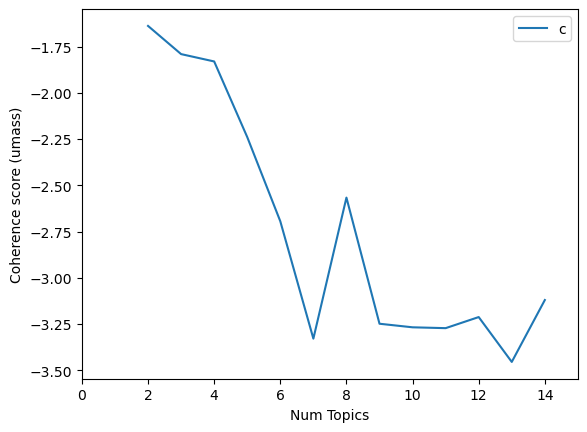

In [13]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 15))
plt.xticks(np.arange(0, 15, step=2))
plt.show()

Umass takes the range of -14 to 14. Higher values indicate that better topics as common words of a topic co-occur frequently within documents. We will take the greatest number of topics before a sharp drop in the coherence score, which is 3 or 4 topics.

References:
https://www.baeldung.com/cs/topic-modeling-coherence-score#:~:text=We%20can%20use%20the%20coherence,words%20are%20to%20each%20other.
https://datascience.oneoffcoder.com/topic-modeling-gensim.html

In [14]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
48       3  0.9099999999999999  0.9099999999999999  -1.669773
47       3  0.9099999999999999                0.61  -1.672240
42       3                0.61                0.61  -1.675591
43       3                0.61  0.9099999999999999  -1.677154
53       3           symmetric  0.9099999999999999  -1.689512
45       3  0.9099999999999999                0.01  -1.701621
41       3                0.61                0.31  -1.707265
44       3                0.61           symmetric  -1.711123
40       3                0.61                0.01  -1.719428
75       4  0.9099999999999999                0.01  -1.720118
38       3                0.31  0.9099999999999999  -1.728127
67       4                0.31                0.61  -1.728833
52       3           symmetric                0.61  -1.730275
37       3                0.31                0.61  -1.731834
70       4                0.61                0.01  -1.735957
36       3                0.31                0.31  -1.736161
46       3  0.9099999999999999                0.31  -1.757449
81       4           symmetric                0.31  -1.759345
39       3                0.31           symmetric  -1.759874
65       4                0.31                0.01  -1.760232
73       4                0.61  0.9099999999999999  -1.760392
64       4                0.01           symmetric  -1.760426
49       3  0.9099999999999999           symmetric  -1.760621
82       4           symmetric                0.61  -1.761054
35       3                0.31                0.01  -1.761094
50       3           symmetric                0.01  -1.761106
66       4                0.31                0.31  -1.764346
72       4                0.61                0.61  -1.769848
51       3           symmetric                0.31  -1.770043
69       4                0.31           symmetric  -1.786685
54       3           symmetric           symmetric  -1.790637
78       4  0.9099999999999999  0.9099999999999999  -1.791517
61       4                0.01                0.31  -1.792083
80       4           symmetric                0.01  -1.797615
60       4                0.01                0.01  -1.802743
30       3                0.01                0.01  -1.804768
77       4  0.9099999999999999                0.61  -1.805549
74       4                0.61           symmetric  -1.808473
76       4  0.9099999999999999                0.31  -1.823390
55       3          asymmetric                0.01  -1.830391
84       4           symmetric           symmetric  -1.830405
79       4  0.9099999999999999           symmetric  -1.833558
71       4                0.61                0.31  -1.851226
85       4          asymmetric                0.01  -1.910525
68       4                0.31  0.9099999999999999  -2.076470
83       4           symmetric  0.9099999999999999  -2.148050
34       3                0.01           symmetric  -2.218079
31       3                0.01                0.31  -2.224495
89       4          asymmetric           symmetric  -2.590787
86       4          asymmetric                0.31  -2.832489
62       4                0.01                0.61  -2.874925
87       4          asymmetric                0.61  -3.100060
59       3          asymmetric           symmetric  -3.263328
56       3          asymmetric                0.31  -3.267525
32       3                0.01                0.61  -3.432906
57       3          asymmetric                0.61  -3.969889
63       4                0.01  0.9099999999999999  -4.141179
88       4          asymmetric  0.9099999999999999  -4.400752
58       3          asymmetric  0.9099999999999999  -4.657099
33       3                0.01  0.9099999999999999  -5.117781

<font color=#61BEB0>**Execute Topic Modelling:**</font>

In [16]:
k=3
a= 0.9099999999999999
b= 0.9099999999999999

lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [17]:
topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.022*"great" + 0.022*"easi" + 0.022*"good" + 0.022*"qualiti" + 0.015*"print" + 0.013*"color" + 0.011*"like" + 0.010*"photo" + 0.009*"copi" + 0.009*"price" + 0.009*"need" + 0.008*"use" + 0.008*"scan" + 0.008*"well" + 0.008*"home" + 0.008*"epson" + 0.007*"love" + 0.007*"tray" + 0.007*"work" + 0.006*"printer"')
(1, '0.015*"cartridg" + 0.015*"time" + 0.015*"work" + 0.014*"buy" + 0.011*"month" + 0.010*"page" + 0.009*"tri" + 0.009*"bought" + 0.008*"would" + 0.008*"new" + 0.008*"dont" + 0.008*"support" + 0.008*"epson" + 0.007*"back" + 0.007*"even" + 0.007*"purchas" + 0.007*"return" + 0.006*"year" + 0.006*"2" + 0.006*"never"')
(2, '0.027*"connect" + 0.023*"work" + 0.016*"wifi" + 0.015*"app" + 0.014*"scan" + 0.014*"instal" + 0.013*"setup" + 0.013*"comput" + 0.011*"phone" + 0.009*"can" + 0.009*"softwar" + 0.008*"wireless" + 0.007*"smart" + 0.007*"tri" + 0.006*"time" + 0.006*"network" + 0.006*"need" + 0.006*"devic" + 0.006*"instruct" + 0.006*"find"')


In [10]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [20]:
visual= pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.096146  0.148172       1        1  41.263523
0     -0.205300 -0.006130       2        1  29.641716
2      0.109155 -0.142042       3        1  29.094761, topic_info=        Term         Freq        Total Category  logprob  loglift
237  connect  3300.000000  3300.000000  Default  30.0000  30.0000
163  qualiti  2645.000000  2645.000000  Default  29.0000  29.0000
1      great  2805.000000  2805.000000  Default  28.0000  28.0000
0       easi  2933.000000  2933.000000  Default  27.0000  27.0000
14      good  2940.000000  2940.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
83       tri   801.140365  2395.063025   Topic3  -5.0107   0.1395
176     need   757.412016  2462.072829   Topic3  -5.0668   0.0558
150     time   774.857679  3542.692659   Topic3  -5.0441  -0.2854
182     want   628.621952  1779.369239   Topic3  -5.2532   0.1941
44       use   647.938674  2451.508704   Topic3  -5.2229  -0.0961

[206 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
270       1  0.709873      2
270       2  0.101791      2
270       3  0.188279      2
271       1  0.909875      3
271       2  0.062255      3
...     ...       ...    ...
133       2  0.167038  would
133       3  0.199023  would
87        1  0.709883   year
87        2  0.280789   year
87        3  0.009228   year

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

From the top key words, we can roughly guess that these are the 3 topics:
- 0: print/scan/photocopy quality
- 1: catridge lifespan
- 2: printer setup and installation

However, the results may be improved by using a bigram model and removing more words that muddy the topic modeling. For example common words like "printer" or "epson" and opinion words like "great" and "like".

<font color=#61BEB0>**Refine Inputs:**</font>

In [289]:
#remove more words
newstop = ['print', "printer", "epson", "canon", "great", "good", "can", "like", "love", "want", "need", "work", "could", "realli", "come", "dont",
           "much", "awesom", "nice", "would", "use", "well", "also", "every", "everyth", "except", "doesnt", "anyth", "even_though", "someth", 
          "disappoint", "im", "still", "wont", "difficult", "guess", "recommend", "cant", "ive", "thing", "think"]
df_processed['Full review'] = df_processed['Full review'].apply(lambda x: " ".join(x for x in x.split() if x not in newstop))

In [290]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

textlist = df_processed['Full review'].values.tolist()
textlist_words = list(sent_to_words(textlist))

In [291]:
#identify phrases
bigram = Phrases(textlist_words, min_count=5, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [292]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

textlist_bigrams = make_bigrams(textlist_words)

In [293]:
dictionary = corpora.Dictionary(textlist_bigrams)

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in textlist_bigrams]

In [47]:
#try 3 topics
k=3
a= 0.9099999999999999
b= 0.9099999999999999

lda_model3 = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [48]:
topics = lda_model3.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.011*"buy" + 0.010*"time" + 0.010*"cartridg" + 0.009*"tri" + 0.008*"bought" + 0.006*"even" + 0.006*"purchas" + 0.006*"month" + 0.006*"page" + 0.006*"return"')
(1, '0.012*"easi" + 0.011*"qualiti" + 0.009*"color" + 0.007*"photo" + 0.006*"copi" + 0.006*"price" + 0.006*"look" + 0.006*"far" + 0.005*"featur" + 0.005*"cartridg"')
(2, '0.013*"app" + 0.012*"comput" + 0.011*"scan" + 0.011*"connect" + 0.011*"wifi" + 0.010*"setup" + 0.009*"instal" + 0.008*"phone" + 0.008*"softwar" + 0.007*"wireless"')


The 3 topics still look quite similar to the first model but the top keywords are more focused.

In [49]:
visual= pyLDAvis.gensim_models.prepare(lda_model3, corpus, dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040645 -0.162728       1        1  39.946368
1     -0.129096  0.114563       2        1  33.972757
2      0.169741  0.048165       3        1  26.080875, topic_info=        Term         Freq        Total Category  logprob  loglift
138      app   963.000000   963.000000  Default  30.0000  30.0000
428  qualiti  1120.000000  1120.000000  Default  29.0000  29.0000
73    comput   912.000000   912.000000  Default  28.0000  28.0000
230  connect   848.000000   848.000000  Default  27.0000  27.0000
265     wifi   843.000000   843.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
149  without   251.277479   646.788311   Topic3  -5.6945   0.3985
404  problem   268.368727   917.640708   Topic3  -5.6287   0.1145
608  scanner   247.012049   672.693678   Topic3  -5.7117   0.3421
123      tri   254.789158  1339.327256   Topic3  -5.6807  -0.3155
239     fine   226.201224   630.723966   Topic3  -5.7997   0.3185

[212 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
494       1  0.357726     abl
494       2  0.091613     abl
494       3  0.551858     abl
788       1  0.981255  amazon
788       2  0.007180  amazon
...     ...       ...     ...
2267      2  0.969561      xp
2267      3  0.009696      xp
68        1  0.628111    year
68        2  0.353220    year
68        3  0.019213    year

[522 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [50]:
fname = "LDA/lda_overall3"
print(fname)
lda_model3.save(fname)

LDA/lda_overall3


In [51]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

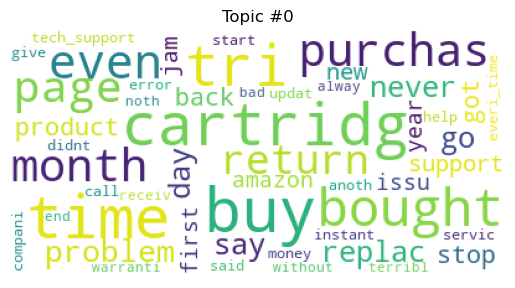

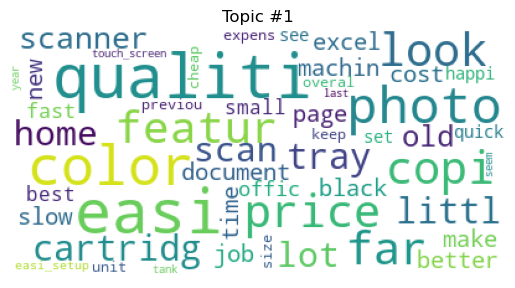

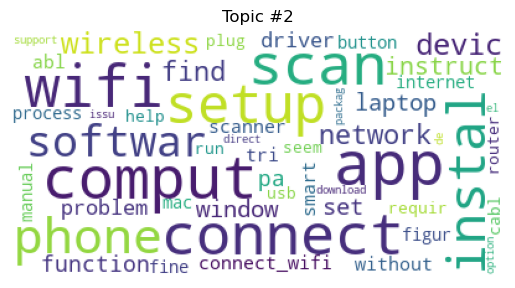

In [52]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [53]:
#try 4 topics
k= 4
a= 0.9099999999999999
b= 0.01

lda_model4 = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [54]:
topics = lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.040*"cartridg" + 0.024*"page" + 0.021*"time" + 0.019*"color" + 0.019*"replac" + 0.018*"even" + 0.015*"photo" + 0.013*"see" + 0.011*"lot" + 0.011*"back" + 0.011*"black" + 0.010*"keep" + 0.010*"cost" + 0.009*"expens" + 0.009*"month"')
(1, '0.037*"scan" + 0.032*"easi" + 0.030*"qualiti" + 0.028*"app" + 0.019*"scanner" + 0.017*"set" + 0.017*"setup" + 0.016*"look" + 0.016*"wireless" + 0.016*"machin" + 0.015*"copi" + 0.015*"featur" + 0.014*"home" + 0.014*"littl" + 0.014*"job"')
(2, '0.034*"buy" + 0.023*"tri" + 0.022*"purchas" + 0.022*"new" + 0.021*"bought" + 0.019*"say" + 0.018*"go" + 0.017*"year" + 0.016*"got" + 0.015*"first" + 0.013*"way" + 0.013*"stop" + 0.012*"never" + 0.012*"last" + 0.012*"phone"')
(3, '0.023*"comput" + 0.022*"connect" + 0.022*"wifi" + 0.019*"product" + 0.018*"issu" + 0.018*"problem" + 0.018*"instal" + 0.017*"support" + 0.015*"softwar" + 0.014*"day" + 0.014*"help" + 0.014*"tech_support" + 0.013*"time" + 0.012*"tri" + 0.011*"devic"')


The 4 topics model appear to be slightly less distinctive than the 3 topics model. These are the possible topic titles:
- 0: catridge lifespan
- 1: print/scan/photocopy quality
- 2: ?
- 3: connecting with other devices

In [55]:
visual= pyLDAvis.gensim_models.prepare(lda_model4, corpus, dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.037212  0.143656       1        1  26.797588
3     -0.098454  0.259845       2        1  25.366334
2     -0.233818 -0.298384       3        1  24.419673
1      0.369484 -0.105117       4        1  23.416404, topic_info=         Term         Freq        Total Category  logprob  loglift
37   cartridg  3034.000000  3034.000000  Default  30.0000  30.0000
387      scan  2496.000000  2496.000000  Default  29.0000  29.0000
111       buy  2433.000000  2433.000000  Default  28.0000  28.0000
39       easi  2143.000000  2143.000000  Default  27.0000  27.0000
428   qualiti  1979.000000  1979.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
826      seem   731.264999  1052.660702   Topic4  -4.5186   1.0874
731      make   771.624652  1345.598755   Topic4  -4.4648   0.8956
85     option   573.199939   789.461404   Topic4  -4.7621   1.1316
456  document   567.137076   983.267568   Topic4  -4.7727   0.9015
17        old   518.093760   988.499543   Topic4  -4.8632   0.8057

[203 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
494       1  0.116737      abl
494       2  0.783308      abl
494       3  0.015176      abl
494       4  0.084051      abl
34        1  0.058687    alway
...     ...       ...      ...
149       3  0.188874  without
149       4  0.252661  without
68        1  0.011898     year
68        3  0.988391     year
749       1  1.000518      yet

[229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [56]:
fname = "LDA/lda_overall4"
print(fname)
lda_model4.save(fname)

LDA/lda_overall4


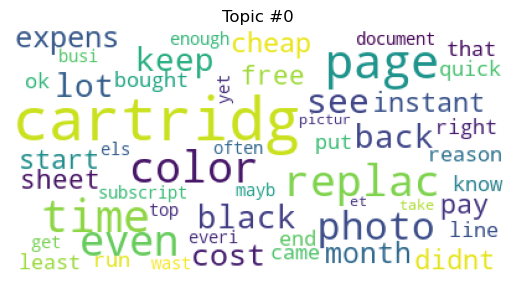

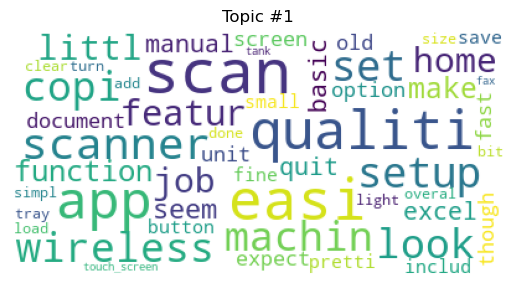

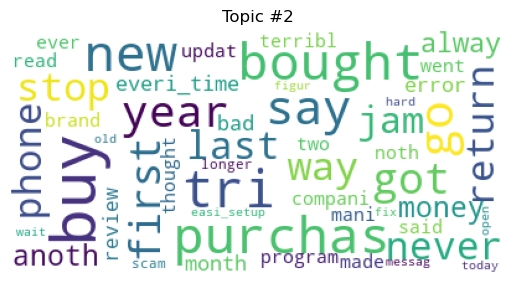

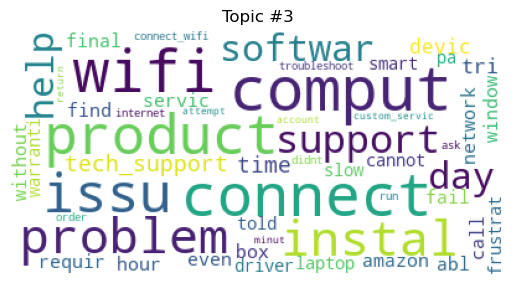

In [57]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### <font color=#FFB703> **Topic Modelling on Each Brand** </font>

<font color=#61BEB0>**Topic Modelling (HP):**</font>

In [58]:
hp_textlist = df_processed['Full review'][df_processed["Brand"]=="HP"].values.tolist()
hp_textlist_words = list(sent_to_words(hp_textlist))
hp_textlist_bigrams = make_bigrams(hp_textlist_words)

hp_dictionary = corpora.Dictionary(hp_textlist_bigrams)
hp_corpus = [hp_dictionary.doc2bow(text) for text in hp_textlist_bigrams]

In [59]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=hp_textlist_bigrams, dictionary=hp_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [61]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=hp_corpus, dictionary=hp_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass_hp.csv', index=False)
    pbar.close()


 10%|███████▌                                                                       | 23/240 [10:46<1:41:35, 28.09s/it]

 55%|███████████████████████████████████████████▋                                    | 131/240 [46:11<48:49, 26.88s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [1:24:53<00:00, 21.22s/it]


In [62]:
lda_results = pd.read_csv("LDA/lda_tuning_results_umass_hp.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.088299
1       2  0.01                0.31  -2.168124
2       2  0.01                0.61  -2.226510
3       2  0.01  0.9099999999999999  -2.383912
4       2  0.01           symmetric  -2.188100

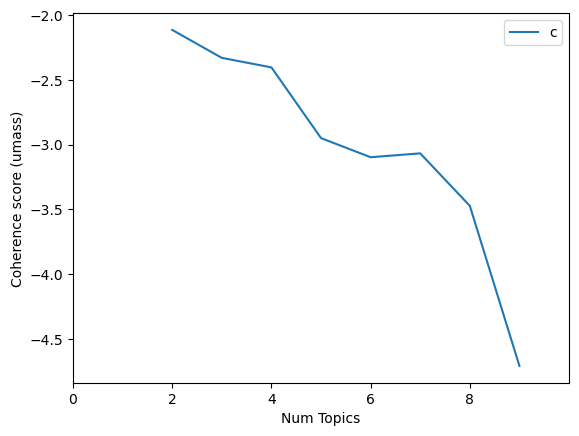

In [63]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [64]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
31       3                0.01                0.31  -2.243207
47       3  0.9099999999999999                0.61  -2.247808
34       3                0.01           symmetric  -2.249692
36       3                0.31                0.31  -2.251796
56       3          asymmetric                0.31  -2.256762
39       3                0.31           symmetric  -2.259807
55       3          asymmetric                0.01  -2.264996
44       3                0.61           symmetric  -2.272856
45       3  0.9099999999999999                0.01  -2.275958
30       3                0.01                0.01  -2.286118
51       3           symmetric                0.31  -2.292019
41       3                0.61                0.31  -2.295322
78       4  0.9099999999999999  0.9099999999999999  -2.300939
49       3  0.9099999999999999           symmetric  -2.302139
48       3  0.9099999999999999  0.9099999999999999  -2.305568
42       3                0.61                0.61  -2.315105
46       3  0.9099999999999999                0.31  -2.317738
59       3          asymmetric           symmetric  -2.326053
80       4           symmetric                0.01  -2.326244
54       3           symmetric           symmetric  -2.330289
76       4  0.9099999999999999                0.31  -2.341421
43       3                0.61  0.9099999999999999  -2.341872
50       3           symmetric                0.01  -2.347867
81       4           symmetric                0.31  -2.367543
72       4                0.61                0.61  -2.369077
40       3                0.61                0.01  -2.370542
35       3                0.31                0.01  -2.370852
77       4  0.9099999999999999                0.61  -2.374557
52       3           symmetric                0.61  -2.401858
84       4           symmetric           symmetric  -2.403789
73       4                0.61  0.9099999999999999  -2.409203
71       4                0.61                0.31  -2.409386
37       3                0.31                0.61  -2.415041
67       4                0.31                0.61  -2.415407
70       4                0.61                0.01  -2.417378
66       4                0.31                0.31  -2.426540
89       4          asymmetric           symmetric  -2.429884
79       4  0.9099999999999999           symmetric  -2.434527
38       3                0.31  0.9099999999999999  -2.449378
75       4  0.9099999999999999                0.01  -2.456587
53       3           symmetric  0.9099999999999999  -2.463801
65       4                0.31                0.01  -2.481911
74       4                0.61           symmetric  -2.491760
61       4                0.01                0.31  -2.510428
60       4                0.01                0.01  -2.517019
86       4          asymmetric                0.31  -2.576209
69       4                0.31           symmetric  -2.582358
64       4                0.01           symmetric  -2.670650
85       4          asymmetric                0.01  -2.703238
82       4           symmetric                0.61  -4.593327
62       4                0.01                0.61  -5.182943
83       4           symmetric  0.9099999999999999  -5.355417
68       4                0.31  0.9099999999999999  -5.369387
63       4                0.01  0.9099999999999999  -5.422216
57       3          asymmetric                0.61  -5.590279
87       4          asymmetric                0.61  -5.670441
58       3          asymmetric  0.9099999999999999  -5.848550
33       3                0.01  0.9099999999999999  -6.574895
32       3                0.01                0.61  -6.868339
88       4          asymmetric  0.9099999999999999 -11.142421

In [76]:
k= 3
a= 0.01
b= 0.31

hp_lda_model3 = gensim.models.LdaModel(corpus=hp_corpus,
                                   id2word=hp_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [77]:
topics = hp_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.012*"tri" + 0.010*"phone" + 0.009*"comput" + 0.009*"help" + 0.009*"connect" + 0.009*"wifi" + 0.009*"day" + 0.008*"time" + 0.008*"easi" + 0.008*"buy" + 0.007*"setup" + 0.006*"bought" + 0.006*"support" + 0.005*"say" + 0.005*"abl"')
(1, '0.022*"cartridg" + 0.010*"purchas" + 0.009*"month" + 0.007*"buy" + 0.007*"instant" + 0.006*"replac" + 0.006*"bought" + 0.005*"program" + 0.005*"page" + 0.005*"even" + 0.005*"new" + 0.005*"free" + 0.005*"product" + 0.005*"compani" + 0.005*"color"')
(2, '0.012*"scan" + 0.009*"app" + 0.007*"time" + 0.005*"featur" + 0.005*"softwar" + 0.005*"page" + 0.005*"price" + 0.005*"document" + 0.004*"scanner" + 0.004*"make" + 0.004*"problem" + 0.004*"support" + 0.004*"photo" + 0.004*"qualiti" + 0.004*"fine"')


The 3 topics model appear somewhat similar to the topics derived from the overall model, but topic 3 is a little less clear in terms of intepretation.
- 0: setup/ installation and tech support
- 1: catridge lifespan
- 2: scanner experience?


In [78]:
visual= pyLDAvis.gensim_models.prepare(hp_lda_model3, hp_corpus, hp_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.179999 -0.126904       1        1  43.160332
0     -0.203661 -0.087276       2        1  29.020762
1      0.023662  0.214179       3        1  27.818906, topic_info=         Term        Freq       Total Category  logprob  loglift
319  cartridg  970.000000  970.000000  Default  30.0000  30.0000
265      scan  844.000000  844.000000  Default  29.0000  29.0000
744     phone  468.000000  468.000000  Default  28.0000  28.0000
78       help  402.000000  402.000000  Default  27.0000  27.0000
36     comput  533.000000  533.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
178      stop  164.811976  277.660365   Topic3  -5.5851   0.7579
293   qualiti  187.705792  499.569925   Topic3  -5.4550   0.3006
129     never  170.404623  334.561086   Topic3  -5.5517   0.6048
191    return  180.441978  482.241705   Topic3  -5.4945   0.2964
123        go  174.946547  562.935320   Topic3  -5.5254   0.1108

[209 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
372       2  0.781829           abl
372       3  0.217525           abl
587       1  0.127282       absolut
587       2  0.798807       absolut
587       3  0.070225       absolut
...     ...       ...           ...
184       1  0.161898          wifi
184       2  0.836824          wifi
1197      2  0.993018  wifi_connect
407       1  0.976857        window
407       3  0.019668        window

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [79]:
fname = "LDA/lda_hp3"
print(fname)
hp_lda_model3.save(fname)

LDA/lda_hp3


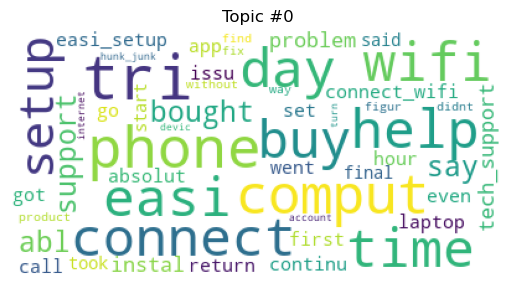

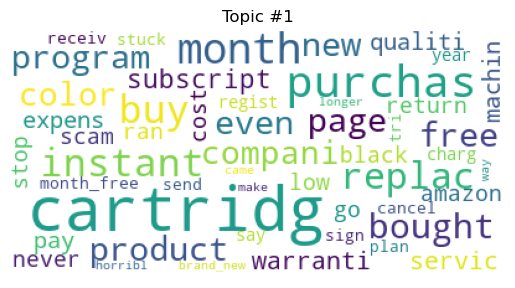

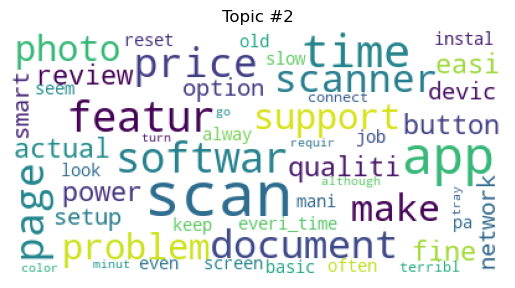

In [80]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(hp_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(hp_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Epson):**</font>

In [70]:
ep_textlist = df_processed['Full review'][df_processed["Brand"]=="Epson"].values.tolist()
ep_textlist_words = list(sent_to_words(ep_textlist))
ep_textlist_bigrams = make_bigrams(ep_textlist_words)

ep_dictionary = corpora.Dictionary(ep_textlist_bigrams)
ep_corpus = [ep_dictionary.doc2bow(text) for text in ep_textlist_bigrams]

In [71]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=ep_textlist_bigrams, dictionary=ep_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [72]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=ep_corpus, dictionary=ep_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass_ep.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [37:17<00:00,  9.32s/it]


In [73]:
lda_results = pd.read_csv("LDA/lda_tuning_results_umass_ep.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.253627
1       2  0.01                0.31  -2.144915
2       2  0.01                0.61  -2.672002
3       2  0.01  0.9099999999999999  -5.484438
4       2  0.01           symmetric  -2.740524

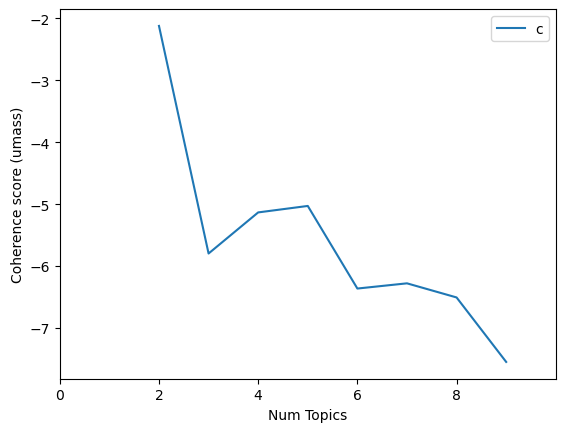

In [74]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [75]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
45       3  0.9099999999999999                0.01  -2.305523
49       3  0.9099999999999999           symmetric  -2.325289
46       3  0.9099999999999999                0.31  -2.330198
40       3                0.61                0.01  -2.368425
35       3                0.31                0.01  -2.391464
50       3           symmetric                0.01  -2.415327
30       3                0.01                0.01  -2.597137
55       3          asymmetric                0.01  -2.800133
41       3                0.61                0.31  -3.180313
44       3                0.61           symmetric  -3.290670
58       3          asymmetric  0.9099999999999999  -3.594275
57       3          asymmetric                0.61  -3.617361
33       3                0.01  0.9099999999999999  -3.655597
43       3                0.61  0.9099999999999999  -3.723670
38       3                0.31  0.9099999999999999  -4.505138
52       3           symmetric                0.61  -4.885065
37       3                0.31                0.61  -4.885486
32       3                0.01                0.61  -4.888042
53       3           symmetric  0.9099999999999999  -4.918862
48       3  0.9099999999999999  0.9099999999999999  -4.924029
47       3  0.9099999999999999                0.61  -5.231058
42       3                0.61                0.61  -5.263468
36       3                0.31                0.31  -5.284204
39       3                0.31           symmetric  -5.626649
31       3                0.01                0.31  -5.632493
51       3           symmetric                0.31  -5.648565
34       3                0.01           symmetric  -5.714047
59       3          asymmetric           symmetric  -5.754940
54       3           symmetric           symmetric  -5.797062
56       3          asymmetric                0.31  -6.031048

In [81]:
k= 3
a= 0.9099999999999999
b= 0.01

ep_lda_model3 = gensim.models.LdaModel(corpus=ep_corpus,
                                   id2word=ep_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [82]:
topics = ep_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.025*"buy" + 0.024*"cartridg" + 0.021*"color" + 0.019*"black" + 0.017*"bought" + 0.015*"run" + 0.014*"replac" + 0.011*"updat" + 0.011*"issu" + 0.011*"year" + 0.010*"go" + 0.010*"way" + 0.010*"see" + 0.010*"get" + 0.010*"month"')
(1, '0.022*"qualiti" + 0.018*"easi" + 0.015*"photo" + 0.012*"tray" + 0.011*"featur" + 0.011*"old" + 0.011*"far" + 0.011*"look" + 0.011*"littl" + 0.010*"seem" + 0.010*"et" + 0.009*"lot" + 0.009*"home" + 0.008*"tank" + 0.008*"price"')
(2, '0.030*"time" + 0.021*"say" + 0.021*"problem" + 0.020*"tri" + 0.019*"everi_time" + 0.018*"page" + 0.016*"even" + 0.015*"solut" + 0.014*"connect" + 0.014*"sheet" + 0.013*"turn" + 0.013*"comput" + 0.012*"job" + 0.012*"product" + 0.012*"first"')


The 3 topics show some similarities to the 3 topics from the overall model but are more difficult to intepret.
- 0: catridge lifespan
- 1: print squality?
- 2: user experience?

In [83]:
visual= pyLDAvis.gensim_models.prepare(ep_lda_model3, ep_corpus, ep_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.338035  0.057641       1        1  36.842796
2      0.115456 -0.301656       2        1  31.771822
0      0.222579  0.244015       3        1  31.385382, topic_info=        Term        Freq       Total Category  logprob  loglift
78      time  745.000000  745.000000  Default  30.0000  30.0000
485      buy  600.000000  600.000000  Default  29.0000  29.0000
351  qualiti  620.000000  620.000000  Default  28.0000  28.0000
356      say  511.000000  511.000000  Default  27.0000  27.0000
436  problem  499.000000  499.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
357      see  246.892558  410.551280   Topic3  -4.5778   0.6503
431      day  228.272718  361.979122   Topic3  -4.6562   0.6978
528     take  184.730183  250.959818   Topic3  -4.8679   0.8524
252  product  222.380947  518.174037   Topic3  -4.6824   0.3129
424  purchas  197.276425  333.963099   Topic3  -4.8022   0.6324

[168 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1086      1  0.029845          abl
1086      3  0.967828          abl
567       1  0.998276          add
563       2  1.001302     advertis
169       3  1.001780        anoth
...     ...       ...          ...
498       3  0.005559      without
499       2  1.000330  worth_money
36        1  0.074553         year
36        3  0.926591         year
868       3  1.002151        youll

[191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [84]:
fname = "LDA/lda_ep3"
print(fname)
ep_lda_model3.save(fname)

LDA/lda_ep3


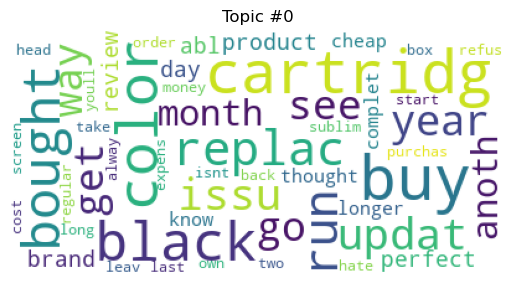

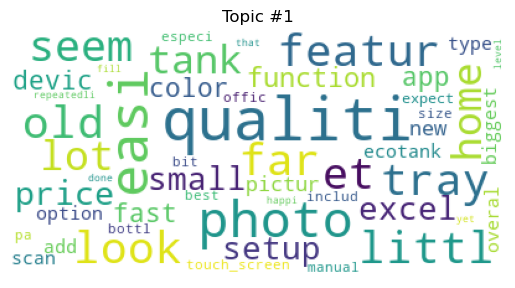

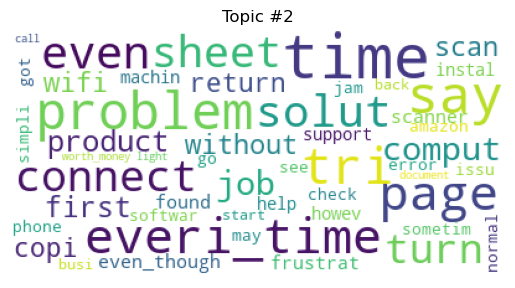

In [85]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(ep_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(ep_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Canon):**</font>

In [86]:
ca_textlist = df_processed['Full review'][df_processed["Brand"]=="Canon"].values.tolist()
ca_textlist_words = list(sent_to_words(ca_textlist))
ca_textlist_bigrams = make_bigrams(ca_textlist_words)

ca_dictionary = corpora.Dictionary(ca_textlist_bigrams)
ca_corpus = [ca_dictionary.doc2bow(text) for text in ca_textlist_bigrams]

In [87]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=ca_textlist_bigrams, dictionary=ca_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [88]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=ca_corpus, dictionary=ca_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass_ca.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [29:30<00:00,  7.38s/it]


In [89]:
lda_results = pd.read_csv("LDA/lda_tuning_results_umass_ca.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.421640
1       2  0.01                0.31  -2.288595
2       2  0.01                0.61  -2.278340
3       2  0.01  0.9099999999999999  -8.106413
4       2  0.01           symmetric  -2.246041

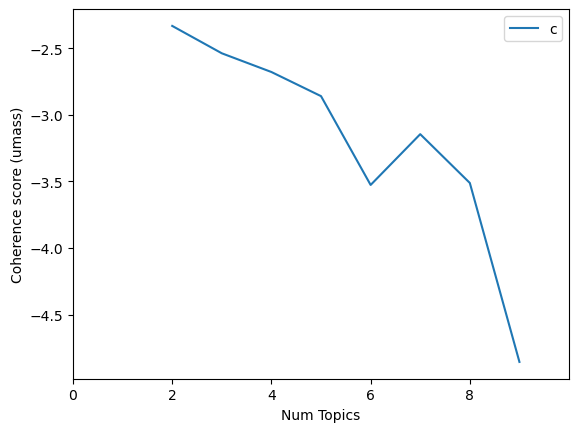

In [90]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [91]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
44       3                0.61           symmetric  -2.394271
39       3                0.31           symmetric  -2.410108
41       3                0.61                0.31  -2.420242
46       3  0.9099999999999999                0.31  -2.426322
51       3           symmetric                0.31  -2.430017
79       4  0.9099999999999999           symmetric  -2.462143
36       3                0.31                0.31  -2.486859
31       3                0.01                0.31  -2.488367
70       4                0.61                0.01  -2.492616
47       3  0.9099999999999999                0.61  -2.498814
76       4  0.9099999999999999                0.31  -2.501061
74       4                0.61           symmetric  -2.502141
49       3  0.9099999999999999           symmetric  -2.513547
71       4                0.61                0.31  -2.518012
35       3                0.31                0.01  -2.531135
50       3           symmetric                0.01  -2.534465
42       3                0.61                0.61  -2.537230
54       3           symmetric           symmetric  -2.538383
75       4  0.9099999999999999                0.01  -2.539097
65       4                0.31                0.01  -2.560332
45       3  0.9099999999999999                0.01  -2.569558
66       4                0.31                0.31  -2.571778
40       3                0.61                0.01  -2.579892
48       3  0.9099999999999999  0.9099999999999999  -2.594809
30       3                0.01                0.01  -2.617947
77       4  0.9099999999999999                0.61  -2.645857
69       4                0.31           symmetric  -2.667070
72       4                0.61                0.61  -2.670092
84       4           symmetric           symmetric  -2.678842
80       4           symmetric                0.01  -2.731694
34       3                0.01           symmetric  -2.836112
60       4                0.01                0.01  -2.855312
81       4           symmetric                0.31  -2.871202
55       3          asymmetric                0.01  -2.961381
52       3           symmetric                0.61  -3.112915
56       3          asymmetric                0.31  -3.227963
62       4                0.01                0.61  -3.242843
64       4                0.01           symmetric  -3.274343
37       3                0.31                0.61  -3.301671
59       3          asymmetric           symmetric  -3.596397
73       4                0.61  0.9099999999999999  -3.597178
67       4                0.31                0.61  -3.608036
85       4          asymmetric                0.01  -3.802098
61       4                0.01                0.31  -4.527748
89       4          asymmetric           symmetric  -4.733335
82       4           symmetric                0.61  -5.492491
78       4  0.9099999999999999  0.9099999999999999  -5.987412
43       3                0.61  0.9099999999999999  -6.352772
57       3          asymmetric                0.61  -6.409236
63       4                0.01  0.9099999999999999  -6.466395
86       4          asymmetric                0.31  -6.505028
32       3                0.01                0.61  -7.639880
87       4          asymmetric                0.61  -8.255441
58       3          asymmetric  0.9099999999999999  -8.330195
33       3                0.01  0.9099999999999999  -8.585722
83       4           symmetric  0.9099999999999999  -9.714728
38       3                0.31  0.9099999999999999 -10.051123
53       3           symmetric  0.9099999999999999 -10.505863
68       4                0.31  0.9099999999999999 -10.827230
88       4          asymmetric  0.9099999999999999 -13.008390

In [92]:
k= 3
a= 0.61
b= "symmetric"

ca_lda_model3= gensim.models.LdaModel(corpus=ca_corpus,
                                   id2word=ca_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [94]:
topics = ca_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.012*"time" + 0.010*"buy" + 0.008*"page" + 0.008*"tri" + 0.008*"even" + 0.007*"jam" + 0.007*"product" + 0.006*"got" + 0.006*"year" + 0.006*"look" + 0.006*"didnt" + 0.006*"cartridg" + 0.005*"new" + 0.005*"back" + 0.005*"first"')
(1, '0.013*"connect" + 0.009*"instal" + 0.009*"problem" + 0.008*"tri" + 0.007*"setup" + 0.007*"instruct" + 0.006*"go" + 0.006*"comput" + 0.006*"phone" + 0.006*"tech_support" + 0.006*"manual" + 0.006*"app" + 0.006*"find" + 0.005*"wifi" + 0.005*"fail"')
(2, '0.015*"easi" + 0.011*"qualiti" + 0.010*"price" + 0.009*"photo" + 0.008*"scanner" + 0.007*"far" + 0.007*"scan" + 0.006*"home" + 0.006*"featur" + 0.006*"color" + 0.006*"tray" + 0.006*"cartridg" + 0.006*"replac" + 0.005*"document" + 0.005*"cheap"')


The 3 topics have similarities with some of the topics derived from the overall model:
- 0: ?
- 1: set-up/installation/connecting to other devices
- 2: catridge lifespan, printer jam


In [95]:
visual= pyLDAvis.gensim_models.prepare(ca_lda_model3, ca_corpus, ca_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.073258 -0.187505       1        1  36.632797
1     -0.144974  0.150481       2        1  32.601733
2      0.218232  0.037024       3        1  30.765471, topic_info=         Term        Freq       Total Category  logprob  loglift
286      easi  241.000000  241.000000  Default  30.0000  30.0000
339   connect  226.000000  226.000000  Default  29.0000  29.0000
378    instal  155.000000  155.000000  Default  28.0000  28.0000
376     photo  145.000000  145.000000  Default  27.0000  27.0000
347     price  157.000000  157.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
172  cartridg   90.002487  223.753391   Topic3  -5.1802   0.2681
23   function   62.970034  115.105829   Topic3  -5.5374   0.5756
46       sure   52.823879   74.778630   Topic3  -5.7131   0.8312
51       turn   58.429341  132.668652   Topic3  -5.6122   0.3587
278      look   52.494110  173.770398   Topic3  -5.7193  -0.0183

[200 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
516       1  0.217676         abl
516       2  0.761865         abl
516       3  0.021768         abl
209       1  0.028504         app
209       2  0.931144         app
...     ...       ...         ...
222       3  0.262555    wireless
316       2  0.974181  worst_ever
57        1  0.849130        year
57        2  0.028304        year
57        3  0.120293        year

[287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [96]:
fname = "LDA/lda_ca3"
print(fname)
ca_lda_model3.save(fname)

LDA/lda_ca3


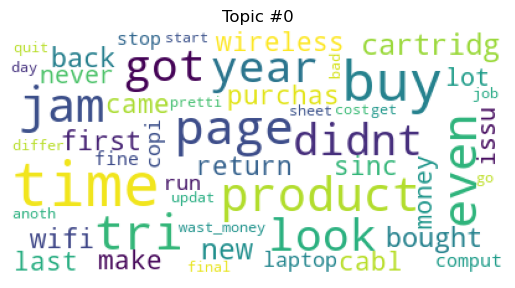

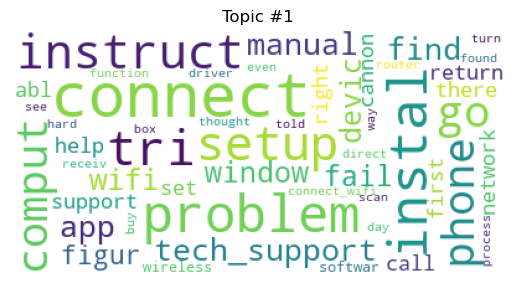

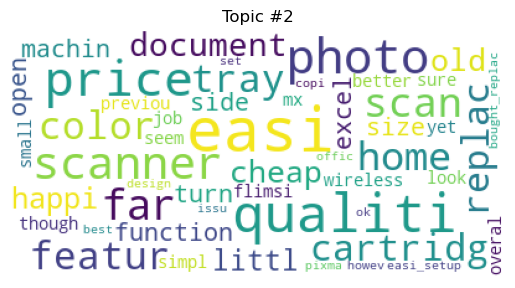

In [102]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(ca_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(ca_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [97]:
#try 4 topics
k= 4
a= 0.9099999999999999
b= "symmetric"

ca_lda_model4= gensim.models.LdaModel(corpus=ca_corpus,
                                   id2word=ca_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [98]:
topics = ca_lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.015*"time" + 0.014*"setup" + 0.011*"page" + 0.009*"look" + 0.009*"got" + 0.008*"wifi" + 0.007*"even" + 0.007*"anoth" + 0.007*"make" + 0.007*"didnt" + 0.007*"laptop" + 0.006*"final" + 0.006*"jam" + 0.006*"lot" + 0.006*"back"')
(1, '0.012*"return" + 0.012*"instal" + 0.009*"cartridg" + 0.009*"instruct" + 0.009*"product" + 0.008*"problem" + 0.008*"support" + 0.008*"tech_support" + 0.008*"even" + 0.008*"purchas" + 0.008*"buy" + 0.007*"tri" + 0.007*"first" + 0.007*"help" + 0.006*"comput"')
(2, '0.019*"easi" + 0.013*"qualiti" + 0.012*"price" + 0.012*"photo" + 0.010*"color" + 0.009*"replac" + 0.009*"function" + 0.008*"far" + 0.008*"cartridg" + 0.008*"featur" + 0.008*"tray" + 0.007*"home" + 0.006*"happi" + 0.005*"cheap" + 0.005*"excel"')
(3, '0.017*"connect" + 0.014*"wireless" + 0.013*"tri" + 0.009*"buy" + 0.008*"scan" + 0.007*"devic" + 0.007*"bought" + 0.007*"year" + 0.007*"time" + 0.007*"copi" + 0.006*"seem" + 0.006*"day" + 0.006*"app" + 0.006*"comput" + 0.006*"cabl"')


The 4 topics have similarities with some of the topics derived from the overall model:
- 0: set-up?
- 1: instructions and support
- 2: catridge lifespan?
- 3: connecting to other devices

In [99]:
visual= pyLDAvis.gensim_models.prepare(ca_lda_model4, ca_corpus, ca_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.154401  0.089797       1        1  26.595536
3     -0.103953 -0.229913       2        1  25.583825
0     -0.013293  0.168799       3        1  24.137061
2      0.271648 -0.028683       4        1  23.683578, topic_info=         Term        Freq       Total Category  logprob  loglift
286      easi  238.000000  238.000000  Default  30.0000  30.0000
339   connect  224.000000  224.000000  Default  29.0000  29.0000
222  wireless  185.000000  185.000000  Default  28.0000  28.0000
176     setup  175.000000  175.000000  Default  27.0000  27.0000
207    return  166.000000  166.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
72        old   61.232991  112.567138   Topic4  -5.3038   0.8315
395    better   52.685383   85.364117   Topic4  -5.4541   0.9578
669   scanner   61.502418  129.768131   Topic4  -5.2994   0.6937
774    machin   47.320942   76.131609   Topic4  -5.5615   0.9649
787      scan   57.990045  164.033925   Topic4  -5.3582   0.4006

[247 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
516       1  0.239848      abl
516       2  0.763152      abl
275       2  0.978732  absolut
252       2  0.967855    alway
252       4  0.032809    alway
...     ...       ...      ...
57        1  0.102681     year
57        2  0.667425     year
57        3  0.036672     year
57        4  0.190693     year
118       3  0.982207     your

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

In [100]:
fname = "LDA/lda_ca4"
print(fname)
ca_lda_model4.save(fname)

LDA/lda_ca4


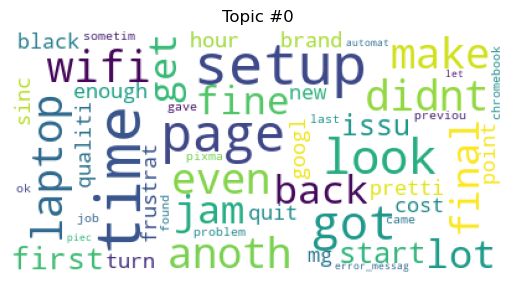

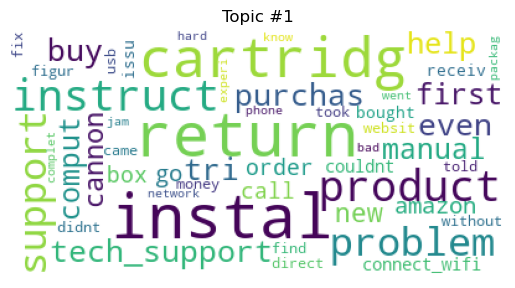

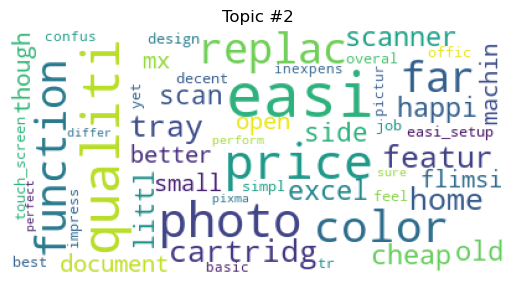

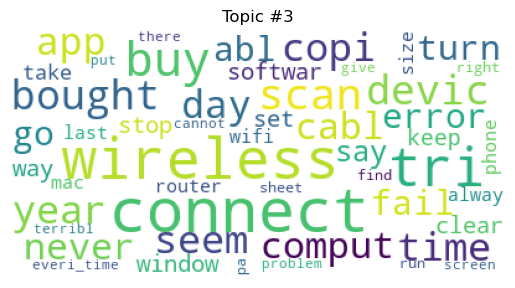

In [101]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(ca_lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(ca_lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### <font color=#FFB703> **Topic Modelling by Review Sentiment** </font>

<font color=#61BEB0>**Topic Modelling (Positive Reviews):**</font>

In [103]:
pve_textlist = df_processed['Full review'][df_processed['Review rating']>=4].values.tolist()
pve_textlist_words = list(sent_to_words(pve_textlist))
pve_textlist_bigrams = make_bigrams(pve_textlist_words)

pve_dictionary = corpora.Dictionary(pve_textlist_bigrams)
pve_corpus = [pve_dictionary.doc2bow(text) for text in pve_textlist_bigrams]

In [104]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=pve_textlist_bigrams, dictionary=pve_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [105]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=pve_corpus, dictionary=pve_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass_pve.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [54:29<00:00, 13.62s/it]


In [106]:
lda_results = pd.read_csv("LDA/lda_tuning_results_umass_pve.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.297507
1       2  0.01                0.31  -2.359472
2       2  0.01                0.61  -5.085003
3       2  0.01  0.9099999999999999  -4.285603
4       2  0.01           symmetric  -3.897984

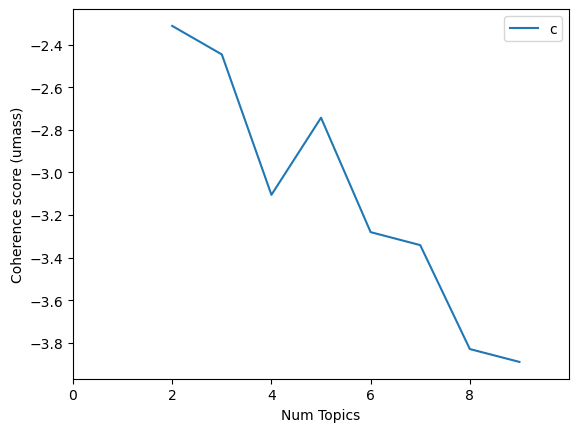

In [107]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [108]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
59       3          asymmetric           symmetric  -2.335417
56       3          asymmetric                0.31  -2.381832
51       3           symmetric                0.31  -2.414825
36       3                0.31                0.31  -2.421069
54       3           symmetric           symmetric  -2.445565
39       3                0.31           symmetric  -2.447889
46       3  0.9099999999999999                0.31  -2.474386
49       3  0.9099999999999999           symmetric  -2.476893
64       4                0.01           symmetric  -2.480612
45       3  0.9099999999999999                0.01  -2.487806
35       3                0.31                0.01  -2.490748
60       4                0.01                0.01  -2.498282
50       3           symmetric                0.01  -2.504585
40       3                0.61                0.01  -2.543368
30       3                0.01                0.01  -2.556992
61       4                0.01                0.31  -2.560044
55       3          asymmetric                0.01  -2.571387
41       3                0.61                0.31  -2.572458
80       4           symmetric                0.01  -2.578078
65       4                0.31                0.01  -2.607117
75       4  0.9099999999999999                0.01  -2.607451
44       3                0.61           symmetric  -2.611871
70       4                0.61                0.01  -2.647686
85       4          asymmetric                0.01  -2.751594
74       4                0.61           symmetric  -2.849373
47       3  0.9099999999999999                0.61  -3.070830
84       4           symmetric           symmetric  -3.105209
79       4  0.9099999999999999           symmetric  -3.121924
82       4           symmetric                0.61  -3.196369
71       4                0.61                0.31  -3.224302
76       4  0.9099999999999999                0.31  -3.259025
31       3                0.01                0.31  -3.343690
42       3                0.61                0.61  -3.399285
34       3                0.01           symmetric  -3.427798
69       4                0.31           symmetric  -3.472091
66       4                0.31                0.31  -3.482447
57       3          asymmetric                0.61  -3.501720
81       4           symmetric                0.31  -3.534422
77       4  0.9099999999999999                0.61  -3.607718
67       4                0.31                0.61  -3.622861
48       3  0.9099999999999999  0.9099999999999999  -3.820231
86       4          asymmetric                0.31  -3.944639
73       4                0.61  0.9099999999999999  -4.024145
89       4          asymmetric           symmetric  -4.088438
72       4                0.61                0.61  -4.100794
52       3           symmetric                0.61  -4.142485
32       3                0.01                0.61  -4.262752
78       4  0.9099999999999999  0.9099999999999999  -4.375059
37       3                0.31                0.61  -4.420768
87       4          asymmetric                0.61  -4.491383
43       3                0.61  0.9099999999999999  -4.895930
53       3           symmetric  0.9099999999999999  -5.026146
58       3          asymmetric  0.9099999999999999  -5.245648
38       3                0.31  0.9099999999999999  -5.618022
68       4                0.31  0.9099999999999999  -6.681779
83       4           symmetric  0.9099999999999999  -6.796533
62       4                0.01                0.61  -7.091676
33       3                0.01  0.9099999999999999  -8.756029
88       4          asymmetric  0.9099999999999999  -9.910859
63       4                0.01  0.9099999999999999 -10.631174

In [109]:
k= 3
a= "asymmetric"
b= "symmetric"

pve_lda_model3 = gensim.models.LdaModel(corpus=pve_corpus,
                                   id2word=pve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [110]:
topics = pve_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.023*"easi" + 0.013*"qualiti" + 0.009*"price" + 0.008*"color" + 0.008*"product" + 0.008*"home" + 0.008*"far" + 0.007*"excel" + 0.007*"buy" + 0.007*"photo" + 0.006*"littl" + 0.006*"easi_setup" + 0.006*"wifi" + 0.006*"look" + 0.006*"lot"')
(1, '0.011*"cartridg" + 0.007*"old" + 0.006*"first" + 0.006*"page" + 0.006*"issu" + 0.006*"didnt" + 0.006*"know" + 0.006*"cost" + 0.006*"time" + 0.006*"review" + 0.005*"new" + 0.005*"go" + 0.005*"month" + 0.005*"bought" + 0.005*"year"')
(2, '0.013*"setup" + 0.013*"app" + 0.009*"scan" + 0.009*"instal" + 0.008*"wifi" + 0.008*"set" + 0.008*"connect" + 0.007*"et" + 0.006*"network" + 0.006*"turn" + 0.006*"fine" + 0.006*"softwar" + 0.006*"option" + 0.006*"comput" + 0.006*"phone"')


The topics are quite hard to intepret. The hyperparameters are probably not optimal.


In [111]:
k= 3
a= "symmetric"
b= "symmetric"

pve_lda_model3 = gensim.models.LdaModel(corpus=pve_corpus,
                                   id2word=pve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [112]:
topics = pve_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.032*"easi" + 0.016*"qualiti" + 0.011*"home" + 0.011*"color" + 0.010*"price" + 0.009*"buy" + 0.009*"easi_setup" + 0.008*"product" + 0.008*"wireless" + 0.007*"look" + 0.007*"littl" + 0.007*"copi" + 0.006*"excel" + 0.006*"fast" + 0.006*"happi"')
(1, '0.009*"cartridg" + 0.008*"issu" + 0.007*"featur" + 0.006*"go" + 0.006*"old" + 0.006*"time" + 0.006*"replac" + 0.006*"month" + 0.005*"page" + 0.005*"year" + 0.005*"first" + 0.005*"bought" + 0.005*"far" + 0.005*"didnt" + 0.005*"know"')
(2, '0.015*"setup" + 0.014*"app" + 0.011*"wifi" + 0.010*"photo" + 0.010*"instal" + 0.009*"connect" + 0.009*"set" + 0.009*"scan" + 0.009*"phone" + 0.008*"comput" + 0.008*"function" + 0.006*"seem" + 0.006*"instruct" + 0.006*"laptop" + 0.006*"document"')


- 0: product quality? ease of use?
- 1: catridge lifepan
- 2: setup and connection to other devices

In [113]:
fname = "LDA/lda_pve3"
print(fname)
pve_lda_model3.save(fname)

LDA/lda_pve3


In [118]:
visual= pyLDAvis.gensim_models.prepare(pve_lda_model3, pve_corpus, pve_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.050176 -0.237246       1        1  41.970346
0     -0.201432  0.158037       2        1  30.817037
2      0.251608  0.079209       3        1  27.212617, topic_info=        Term         Freq        Total Category  logprob  loglift
7       easi  1003.000000  1003.000000  Default  30.0000  30.0000
44     setup   429.000000   429.000000  Default  29.0000  29.0000
39       app   395.000000   395.000000  Default  28.0000  28.0000
157  qualiti   581.000000   581.000000  Default  27.0000  27.0000
316     home   348.000000   348.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
414   easili   121.259385   161.200222   Topic3  -5.4297   1.0168
519   option   121.583640   211.253264   Topic3  -5.4271   0.7490
372  problem   135.644688   311.445569   Topic3  -5.3176   0.4703
265      tri   112.254818   282.240818   Topic3  -5.5069   0.3795
108    excel   106.446503   306.711080   Topic3  -5.5600   0.2432

[178 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.009208   absolut
1         2  0.994470   absolut
727       1  0.010355   allison
727       2  0.994123   allison
55        3  0.987655     allow
...     ...       ...       ...
205       3  0.994335    window
344       2  0.995265  wireless
344       3  0.004235  wireless
37        1  0.849601      year
37        2  0.150145      year

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

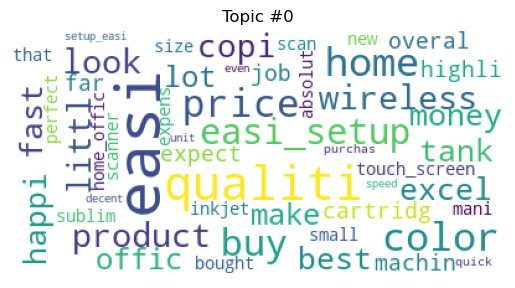

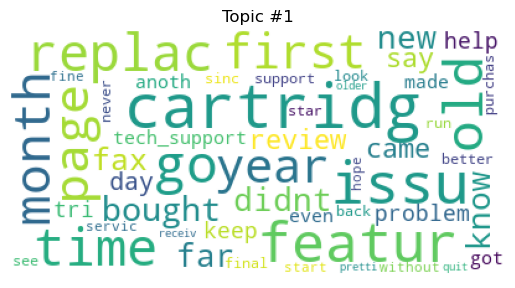

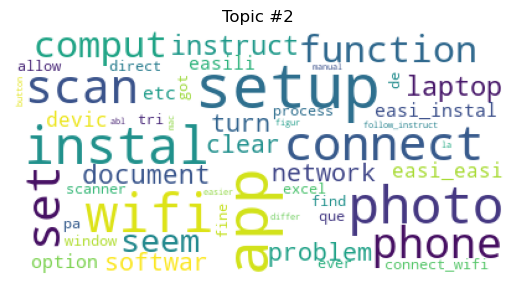

In [117]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(pve_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(pve_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [114]:
#try 4 topics
k= 4
a= 0.01
b= "symmetric"

pve_lda_model4 = gensim.models.LdaModel(corpus=pve_corpus,
                                   id2word=pve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [115]:
topics = pve_lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.035*"easi" + 0.017*"bought" + 0.017*"home" + 0.016*"qualiti" + 0.015*"excel" + 0.014*"phone" + 0.013*"easi_setup" + 0.012*"product" + 0.011*"look" + 0.011*"wireless" + 0.011*"copi" + 0.010*"start" + 0.009*"color" + 0.008*"laptop" + 0.007*"final"')
(1, '0.016*"cartridg" + 0.011*"featur" + 0.010*"old" + 0.010*"replac" + 0.009*"far" + 0.008*"year" + 0.007*"review" + 0.007*"better" + 0.007*"last" + 0.007*"time" + 0.006*"keep" + 0.006*"know" + 0.006*"wifi" + 0.006*"made" + 0.006*"et"')
(2, '0.013*"scan" + 0.011*"photo" + 0.010*"tri" + 0.009*"app" + 0.008*"page" + 0.007*"qualiti" + 0.007*"set" + 0.007*"devic" + 0.007*"tank" + 0.007*"wifi" + 0.006*"connect" + 0.006*"new" + 0.006*"previou" + 0.006*"offic" + 0.006*"option"')
(3, '0.013*"setup" + 0.012*"issu" + 0.009*"instal" + 0.009*"fast" + 0.008*"without" + 0.008*"price" + 0.007*"seem" + 0.007*"fine" + 0.007*"buy" + 0.007*"money" + 0.007*"go" + 0.007*"see" + 0.006*"new" + 0.006*"tech_support" + 0.006*"easi"')


The topics are not very coherent.
- 0: wifi set-up?
- 1: ?
- 2: scan quality
- 3: installaion and setup? value for money?

In [119]:
fname = "LDA/lda_pve4"
print(fname)
pve_lda_model4.save(fname)

LDA/lda_pve4


<font color=#61BEB0>**Topic Modelling (Negative Reviews):**</font>

In [120]:
nve_textlist = df_processed['Full review'][df_processed['Review rating']<=2].values.tolist()
nve_textlist_words = list(sent_to_words(nve_textlist))
nve_textlist_bigrams = make_bigrams(nve_textlist_words)

nve_dictionary = corpora.Dictionary(nve_textlist_bigrams)
nve_corpus = [nve_dictionary.doc2bow(text) for text in nve_textlist_bigrams]

In [121]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=nve_textlist_bigrams, dictionary=nve_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [122]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=nve_corpus, dictionary=nve_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass_nve.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [1:05:12<00:00, 16.30s/it]


In [123]:
lda_results = pd.read_csv("LDA/lda_tuning_results_umass_nve.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.148301
1       2  0.01                0.31  -2.125086
2       2  0.01                0.61  -2.131907
3       2  0.01  0.9099999999999999  -2.868828
4       2  0.01           symmetric  -2.166906

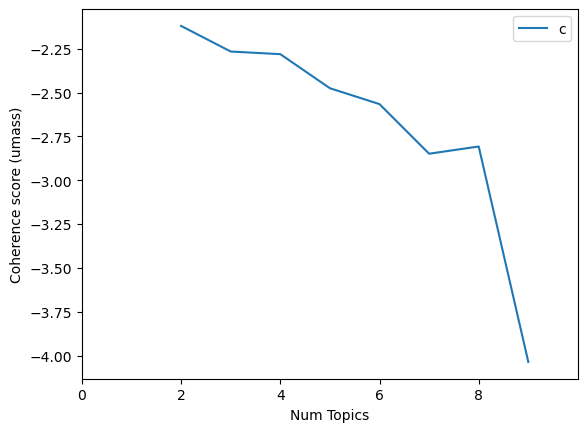

In [124]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [125]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
55       3          asymmetric                0.01  -2.194460
81       4           symmetric                0.31  -2.196891
34       3                0.01           symmetric  -2.209024
43       3                0.61  0.9099999999999999  -2.214099
74       4                0.61           symmetric  -2.214952
40       3                0.61                0.01  -2.215524
31       3                0.01                0.31  -2.229225
36       3                0.31                0.31  -2.239378
52       3           symmetric                0.61  -2.239590
77       4  0.9099999999999999                0.61  -2.245196
39       3                0.31           symmetric  -2.249140
79       4  0.9099999999999999           symmetric  -2.249433
41       3                0.61                0.31  -2.249519
45       3  0.9099999999999999                0.01  -2.255746
76       4  0.9099999999999999                0.31  -2.261929
73       4                0.61  0.9099999999999999  -2.264356
71       4                0.61                0.31  -2.265150
54       3           symmetric           symmetric  -2.265689
44       3                0.61           symmetric  -2.266586
70       4                0.61                0.01  -2.268599
69       4                0.31           symmetric  -2.269023
42       3                0.61                0.61  -2.270474
51       3           symmetric                0.31  -2.272997
67       4                0.31                0.61  -2.277506
84       4           symmetric           symmetric  -2.280700
78       4  0.9099999999999999  0.9099999999999999  -2.282329
37       3                0.31                0.61  -2.284134
65       4                0.31                0.01  -2.289329
35       3                0.31                0.01  -2.295263
75       4  0.9099999999999999                0.01  -2.298581
30       3                0.01                0.01  -2.301341
48       3  0.9099999999999999  0.9099999999999999  -2.309413
47       3  0.9099999999999999                0.61  -2.310478
49       3  0.9099999999999999           symmetric  -2.311778
50       3           symmetric                0.01  -2.318116
80       4           symmetric                0.01  -2.319089
46       3  0.9099999999999999                0.31  -2.330760
66       4                0.31                0.31  -2.335754
72       4                0.61                0.61  -2.345347
59       3          asymmetric           symmetric  -2.347360
56       3          asymmetric                0.31  -2.355390
60       4                0.01                0.01  -2.364006
85       4          asymmetric                0.01  -2.408841
61       4                0.01                0.31  -2.414176
64       4                0.01           symmetric  -2.448549
57       3          asymmetric                0.61  -2.477505
86       4          asymmetric                0.31  -2.500017
82       4           symmetric                0.61  -2.613664
89       4          asymmetric           symmetric  -2.671635
53       3           symmetric  0.9099999999999999  -2.692185
38       3                0.31  0.9099999999999999  -2.705103
32       3                0.01                0.61  -2.903954
58       3          asymmetric  0.9099999999999999  -3.859759
62       4                0.01                0.61  -5.370227
87       4          asymmetric                0.61  -5.859487
33       3                0.01  0.9099999999999999  -6.739096
68       4                0.31  0.9099999999999999  -6.744806
88       4          asymmetric  0.9099999999999999  -6.898235
83       4           symmetric  0.9099999999999999  -7.837309
63       4                0.01  0.9099999999999999  -9.220601

In [126]:
k= 3
a= "asymmetric"
b= 0.01

nve_lda_model3 = gensim.models.LdaModel(corpus=nve_corpus,
                                   id2word=nve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [127]:
topics = nve_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.020*"time" + 0.016*"scan" + 0.014*"tri" + 0.012*"page" + 0.012*"even" + 0.011*"buy" + 0.009*"go" + 0.009*"app" + 0.008*"bought" + 0.008*"color" + 0.008*"qualiti" + 0.007*"never" + 0.007*"scanner" + 0.007*"wifi" + 0.007*"month"')
(1, '0.019*"support" + 0.017*"softwar" + 0.014*"instal" + 0.013*"return" + 0.012*"help" + 0.012*"comput" + 0.012*"problem" + 0.011*"devic" + 0.011*"said" + 0.011*"amazon" + 0.011*"call" + 0.011*"day" + 0.011*"new" + 0.010*"connect" + 0.010*"tri"')
(2, '0.079*"cartridg" + 0.026*"buy" + 0.019*"compani" + 0.018*"scam" + 0.016*"account" + 0.016*"instant" + 0.015*"allow" + 0.015*"without" + 0.014*"plan" + 0.014*"updat" + 0.014*"subscript" + 0.013*"purchas" + 0.013*"bought" + 0.013*"charg" + 0.011*"pay"')


Topics are not very intepretable.
- 0: ?
- 1: installation?
- 2: catridge replacements>

In [128]:
visual= pyLDAvis.gensim_models.prepare(nve_lda_model3, nve_corpus, nve_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.117932  0.242615       1        1  58.668898
1     -0.216844 -0.199111       2        1  28.971597
2      0.334776 -0.043504       3        1  12.359505, topic_info=          Term         Freq        Total Category  logprob  loglift
304   cartridg  1414.000000  1414.000000  Default  30.0000  30.0000
0          buy  1544.000000  1544.000000  Default  29.0000  29.0000
235    support   797.000000   797.000000  Default  28.0000  28.0000
12        time  1678.000000  1678.000000  Default  27.0000  27.0000
435    softwar   691.000000   691.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1048     brand   147.879962   245.677776   Topic3  -4.7862   1.5831
575     bought   224.404002  1013.342256   Topic3  -4.3691   0.5832
514        let   155.334821   301.094075   Topic3  -4.7370   1.4289
69         say   168.698927   700.716107   Topic3  -4.6545   0.6668
350      money   142.903455   334.805456   Topic3  -4.8204   1.2394

[178 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
29        3  0.999907     account
32        3  1.001225       allow
133       1  1.001177       alway
616       2  0.999994      amazon
76        1  0.851596         app
...     ...       ...         ...
865       1  0.999992    wireless
866       3  0.998304  wirelessli
75        1  0.568603     without
75        3  0.431809     without
167       1  1.001244  worst_ever

[202 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [129]:
fname = "LDA/lda_nve3"
print(fname)
nve_lda_model3.save(fname)

LDA/lda_nve3


In [130]:
#try 4 topics
k= 4
a= "symmetric"
b= 0.31

nve_lda_model4 = gensim.models.LdaModel(corpus=nve_corpus,
                                   id2word=nve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [131]:
topics = nve_lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.013*"time" + 0.012*"page" + 0.011*"scan" + 0.009*"qualiti" + 0.008*"photo" + 0.008*"color" + 0.008*"job" + 0.008*"tray" + 0.007*"tri" + 0.007*"machin" + 0.007*"buy" + 0.007*"even" + 0.006*"document" + 0.006*"jam" + 0.005*"black"')
(1, '0.015*"replac" + 0.014*"return" + 0.009*"amazon" + 0.009*"problem" + 0.008*"bought" + 0.008*"support" + 0.008*"day" + 0.007*"purchas" + 0.007*"month" + 0.007*"issu" + 0.007*"got" + 0.006*"new" + 0.006*"stop" + 0.006*"error" + 0.006*"warranti"')
(2, '0.025*"cartridg" + 0.013*"buy" + 0.008*"compani" + 0.007*"purchas" + 0.006*"even" + 0.006*"scam" + 0.006*"say" + 0.006*"bought" + 0.005*"account" + 0.005*"go" + 0.005*"pay" + 0.005*"instant" + 0.005*"updat" + 0.005*"product" + 0.005*"expens"')
(3, '0.011*"comput" + 0.010*"tri" + 0.010*"app" + 0.009*"connect" + 0.008*"scan" + 0.008*"time" + 0.008*"softwar" + 0.007*"wifi" + 0.006*"instal" + 0.006*"problem" + 0.006*"wireless" + 0.006*"even" + 0.005*"run" + 0.005*"devic" + 0.005*"issu"')


- 0: user experience
- 1: amazon returns? waaranty?
- 2: catridge replacement?
- 3: connecting to other devices

In [132]:
fname = "LDA/lda_nve4"
print(fname)
nve_lda_model4.save(fname)

LDA/lda_nve4


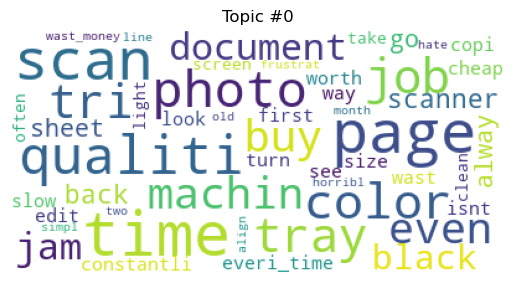

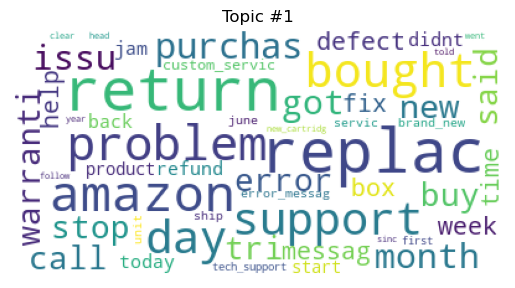

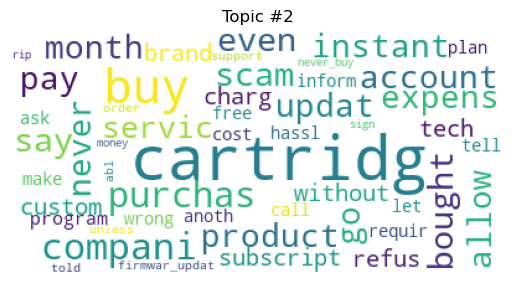

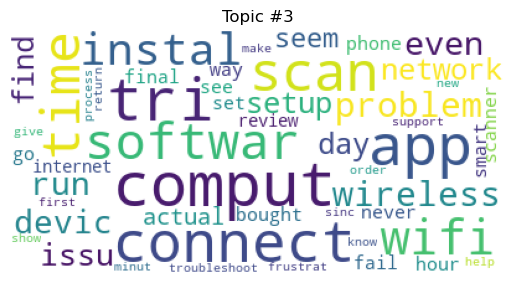

In [133]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(nve_lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(nve_lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Neutral Reviews):**</font>

In [134]:
neu_textlist = df_processed['Full review'][df_processed['Review rating']==3].values.tolist()
neu_textlist_words = list(sent_to_words(neu_textlist))
neu_textlist_bigrams = make_bigrams(neu_textlist_words)

neu_dictionary = corpora.Dictionary(neu_textlist_bigrams)
neu_corpus = [neu_dictionary.doc2bow(text) for text in neu_textlist_bigrams]

In [135]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=neu_textlist_bigrams, dictionary=neu_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [136]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=neu_corpus, dictionary=neu_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('LDA/lda_tuning_results_umass_neu.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [20:27<00:00,  5.11s/it]


In [137]:
lda_results = pd.read_csv("LDA/lda_tuning_results_umass_neu.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.428539
1       2  0.01                0.31  -2.644291
2       2  0.01                0.61  -2.475231
3       2  0.01  0.9099999999999999  -7.861401
4       2  0.01           symmetric  -2.327082

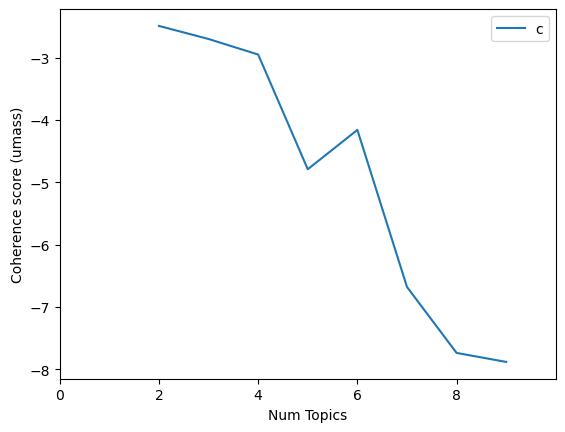

In [138]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [140]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
50       3           symmetric                0.01  -2.450732
45       3  0.9099999999999999                0.01  -2.492270
40       3                0.61                0.01  -2.520919
80       4           symmetric                0.01  -2.533850
60       4                0.01                0.01  -2.538376
75       4  0.9099999999999999                0.01  -2.554464
41       3                0.61                0.31  -2.555284
65       4                0.31                0.01  -2.555343
31       3                0.01                0.31  -2.557814
44       3                0.61           symmetric  -2.574135
46       3  0.9099999999999999                0.31  -2.580853
35       3                0.31                0.01  -2.582392
70       4                0.61                0.01  -2.584998
34       3                0.01           symmetric  -2.597863
42       3                0.61                0.61  -2.602313
49       3  0.9099999999999999           symmetric  -2.619471
51       3           symmetric                0.31  -2.627960
30       3                0.01                0.01  -2.628002
39       3                0.31           symmetric  -2.642126
36       3                0.31                0.31  -2.682311
54       3           symmetric           symmetric  -2.702865
52       3           symmetric                0.61  -2.710910
47       3  0.9099999999999999                0.61  -2.794532
66       4                0.31                0.31  -2.795102
55       3          asymmetric                0.01  -2.800912
37       3                0.31                0.61  -2.854902
61       4                0.01                0.31  -2.918239
84       4           symmetric           symmetric  -2.951823
64       4                0.01           symmetric  -2.952702
76       4  0.9099999999999999                0.31  -3.043792
69       4                0.31           symmetric  -3.049004
79       4  0.9099999999999999           symmetric  -3.053778
71       4                0.61                0.31  -3.105490
81       4           symmetric                0.31  -3.148600
74       4                0.61           symmetric  -3.369383
85       4          asymmetric                0.01  -3.890114
32       3                0.01                0.61  -3.969669
48       3  0.9099999999999999  0.9099999999999999  -4.187167
77       4  0.9099999999999999                0.61  -4.348728
67       4                0.31                0.61  -4.558357
78       4  0.9099999999999999  0.9099999999999999  -5.448594
62       4                0.01                0.61  -5.490587
72       4                0.61                0.61  -5.579257
43       3                0.61  0.9099999999999999  -5.936394
56       3          asymmetric                0.31  -5.968252
68       4                0.31  0.9099999999999999  -6.099563
59       3          asymmetric           symmetric  -6.272724
82       4           symmetric                0.61  -6.317350
73       4                0.61  0.9099999999999999  -6.339430
89       4          asymmetric           symmetric  -6.368120
83       4           symmetric  0.9099999999999999  -6.872749
53       3           symmetric  0.9099999999999999  -7.014536
38       3                0.31  0.9099999999999999  -7.181371
63       4                0.01  0.9099999999999999  -7.301742
58       3          asymmetric  0.9099999999999999  -7.996391
86       4          asymmetric                0.31  -8.856522
88       4          asymmetric  0.9099999999999999  -9.145574
57       3          asymmetric                0.61  -9.484902
33       3                0.01  0.9099999999999999 -10.440946
87       4          asymmetric                0.61 -11.048652

In [141]:
#try 3 topics
k= 3
a= "symmetric"
b= 0.01

neu_lda_model3 = gensim.models.LdaModel(corpus=neu_corpus,
                                   id2word=neu_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [142]:
topics = neu_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.029*"cartridg" + 0.028*"scan" + 0.016*"instal" + 0.016*"updat" + 0.016*"tech_support" + 0.015*"comput" + 0.013*"scanner" + 0.013*"lot" + 0.012*"setup" + 0.011*"featur" + 0.011*"tri" + 0.011*"softwar" + 0.010*"stop" + 0.010*"app" + 0.010*"window"')
(1, '0.017*"qualiti" + 0.013*"time" + 0.013*"better" + 0.012*"connect" + 0.011*"wireless" + 0.011*"light" + 0.011*"job" + 0.011*"wifi" + 0.011*"cheap" + 0.011*"fine" + 0.009*"keep" + 0.009*"color" + 0.009*"part" + 0.009*"easi" + 0.008*"price"')
(2, '0.018*"time" + 0.018*"purchas" + 0.016*"page" + 0.015*"new" + 0.014*"go" + 0.014*"got" + 0.013*"document" + 0.013*"say" + 0.012*"littl" + 0.011*"turn" + 0.011*"jam" + 0.011*"frustrat" + 0.011*"problem" + 0.011*"year" + 0.010*"first"')


Topics are not very coherent.
- 0: functionalities?
- 1: ?
- 2: ?

In [143]:
visual= pyLDAvis.gensim_models.prepare(neu_lda_model3, neu_corpus, neu_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.065726 -0.277936       1        1  35.304902
2     -0.231398  0.190813       2        1  34.904543
0      0.297124  0.087123       3        1  29.790555, topic_info=             Term        Freq       Total Category  logprob  loglift
556          scan  397.000000  397.000000  Default  30.0000  30.0000
132      cartridg  446.000000  446.000000  Default  29.0000  29.0000
271        instal  202.000000  202.000000  Default  28.0000  28.0000
643         updat  197.000000  197.000000  Default  27.0000  27.0000
263  tech_support  191.000000  191.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
126           tri  134.412569  305.586746   Topic3  -4.5180   0.3897
425         start   99.883312  148.415777   Topic3  -4.8149   0.8150
145          sure   95.286778  139.171728   Topic3  -4.8620   0.8322
245          find   96.723358  214.190834   Topic3  -4.8470   0.4160
246          fine   97.802054  252.418510   Topic3  -4.8359   0.2628

[184 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
329       1  0.998352    actual
534       2  1.004406       add
648       3  1.006039     addit
1252      1  1.003425    afford
178       1  1.005193    almost
...     ...       ...       ...
253       3  0.120995      wifi
128       3  0.995733    window
129       1  1.002118  wireless
107       1  0.159498      year
107       2  0.841492      year

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [144]:
fname = "LDA/lda_neu3"
print(fname)
neu_lda_model3.save(fname)

LDA/lda_neu3


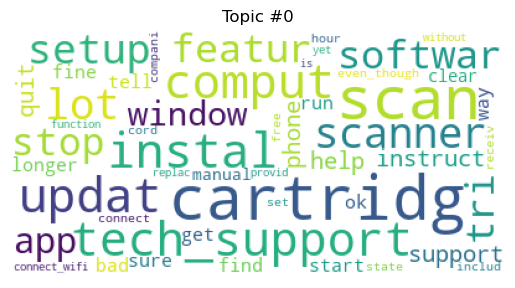

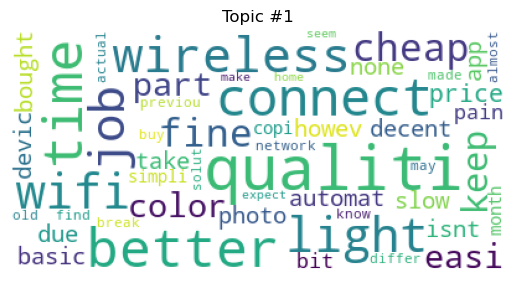

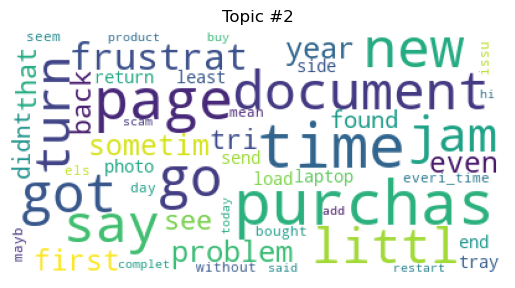

In [145]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(neu_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(neu_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [146]:
#try 4 topics
k= 4
a= "symmetric"
b= 0.01

neu_lda_model4 = gensim.models.LdaModel(corpus=neu_corpus,
                                   id2word=neu_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [147]:
topics = neu_lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.040*"scan" + 0.021*"tech_support" + 0.017*"scanner" + 0.016*"help" + 0.015*"updat" + 0.015*"stop" + 0.015*"easi" + 0.015*"cartridg" + 0.014*"instal" + 0.014*"app" + 0.013*"run" + 0.013*"quit" + 0.011*"featur" + 0.011*"comput" + 0.011*"support"')
(1, '0.022*"time" + 0.018*"qualiti" + 0.016*"better" + 0.014*"job" + 0.014*"cheap" + 0.013*"jam" + 0.011*"part" + 0.011*"littl" + 0.010*"take" + 0.010*"keep" + 0.010*"slow" + 0.010*"copi" + 0.009*"decent" + 0.009*"fine" + 0.009*"got"')
(2, '0.034*"cartridg" + 0.021*"purchas" + 0.020*"time" + 0.017*"say" + 0.016*"page" + 0.015*"sometim" + 0.014*"hour" + 0.014*"didnt" + 0.013*"return" + 0.013*"problem" + 0.013*"even" + 0.013*"go" + 0.013*"day" + 0.013*"bought" + 0.012*"longer"')
(3, '0.025*"connect" + 0.018*"wifi" + 0.016*"setup" + 0.015*"wireless" + 0.015*"without" + 0.014*"comput" + 0.014*"tri" + 0.011*"devic" + 0.010*"fine" + 0.010*"found" + 0.010*"everi_time" + 0.010*"load" + 0.010*"previou" + 0.009*"tray" + 0.009*"bad"')


Topics are not very intepretable. 

- 0: ease of use? support?
- 1: print speed and quality?
- 2: catridge lifespan?
- 3: connecting to other devices

In [148]:
visual= pyLDAvis.gensim_models.prepare(neu_lda_model4, neu_corpus, neu_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.138657  0.271443       1        1  27.390830
1     -0.199408 -0.152746       2        1  27.339730
2     -0.186153  0.089572       3        1  23.215814
0      0.246903 -0.208269       4        1  22.053626, topic_info=             Term        Freq       Total Category  logprob  loglift
556          scan  391.000000  391.000000  Default  30.0000  30.0000
132      cartridg  458.000000  458.000000  Default  29.0000  29.0000
183       connect  284.000000  284.000000  Default  28.0000  28.0000
278          time  446.000000  446.000000  Default  27.0000  27.0000
263  tech_support  189.000000  189.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
46            lot   83.131422  155.712943   Topic4  -4.6977   0.8841
50           page   95.167247  250.239749   Topic4  -4.5625   0.5449
145          sure   76.397415  138.766541   Topic4  -4.7822   0.9148
245          find   80.449480  215.153039   Topic4  -4.7305   0.5280
638        replac   76.310165  171.166235   Topic4  -4.7834   0.7039

[240 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
329       2  0.998698   actual
648       4  0.999360    addit
1252      2  0.999374   afford
178       2  1.005363   almost
431       4  1.001294  alreadi
...     ...       ...      ...
497       3  0.996550       xp
1022      3  1.009882       ye
107       2  0.442383     year
107       3  0.559979     year
1068      4  0.997327    youll

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [151]:
fname = "LDA/lda_neu4"
print(fname)
neu_lda_model4.save(fname)

LDA/lda_neu4


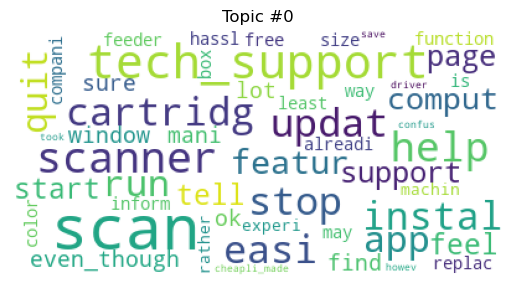

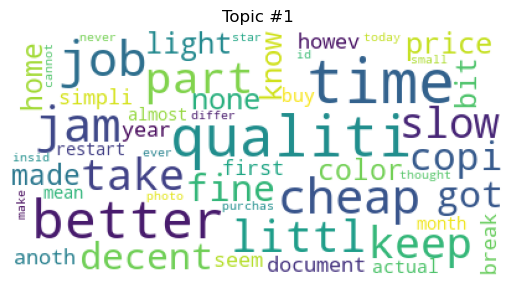

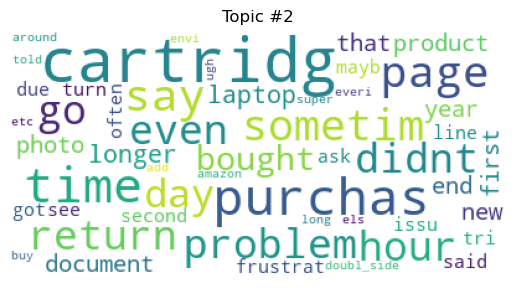

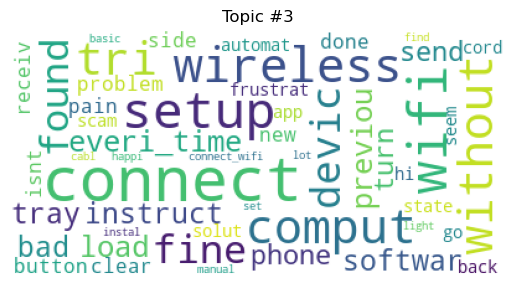

In [150]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(neu_lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(neu_lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### <font color=#FFB703> **Topic Modelling on Full Unprocessed Corpus** </font>

In [281]:
df_processed['Original_full'] = df_processed['Original title'].astype(str) +" " + df_processed["Original review"].astype(str)

processed_data = df_processed['Original_full'].apply(lambda x: simple_preprocess(str(x)) if isinstance(x, str) else [])
processed_data.head(5)

0    [works, great, was, easy, to, install, and, wo...
1    [spunky, mid, size, printer, slower, print, sp...
2                            [𝙲𝚕𝚎𝚊𝚛, 𝚙𝚛𝚒𝚗𝚝𝚜, 𝙻𝚘𝚟𝚎, 𝚒𝚝]
3    [shaq, knows, what, he, talking, about, yup, t...
4    [not, user, friendly, you, would, think, somet...
Name: Original_full, dtype: object

In [312]:
stoplist = stopwords.words('english')
new_stopwords = ["hp", "epson", "canon", "great", "good", "can", "like", "love", "want", "need", "work", "could", "new", "old",
                 "find", "really", "come", "dont", "much", "awesome", "nice", "would", "use", "well", "also", "every", 
                 "fine", "one", "everything", "except", "doesnt", "anything", "something", "bad", "happy", "thing", "la", "le",
                 "yes", "nan", "even", "though", "around", "work", "printer", "printers", "especially", "paper", "et", "que",
                 "worked", "working", "de", "el", "quite", "ok", "horrible", "easy", "better", "although", "still",
                 "disappointed", "disappoint", "far", "excellent", "absolutely", "envy", "works", "working", "used", "use",
                 "difficult", "brand", "else", "office", "home", "model", "came", "need", "needs", "needed", "printing"]
stoplist.extend(new_stopwords)
print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [313]:
#remove stopwords and lemmatise
st = PorterStemmer()
procesed_nostop_data = [[st.stem(word) for word in doc if word not in stoplist] for doc in processed_data]
procesed_nostop_data[0:5]

[['instal'],
 ['spunki',
  'mid',
  'size',
  'slower',
  'print',
  'speed',
  'oj',
  'pro',
  'sound',
  'break',
  'apart',
  'insid',
  'setup',
  'annoyingli',
  'complex',
  'luckili',
  'research',
  'watch',
  'review',
  'opt',
  'enrol',
  'import',
  'know',
  'detail',
  'enrol',
  'instant',
  'ink',
  'program',
  'terrif',
  'hope',
  'ruin',
  'overal',
  'spunki',
  'mid',
  'size',
  'enough',
  'typic'],
 ['𝙲𝚕𝚎𝚊𝚛', '𝚙𝚛𝚒𝚗𝚝𝚜', '𝙻𝚘𝚟𝚎', '𝚒𝚝'],
 ['shaq',
  'know',
  'talk',
  'yup',
  'slam',
  'dunk',
  'upgrad',
  'paid',
  'littl',
  'front',
  'equival',
  'throw',
  'away',
  'type',
  'cartridg',
  'save',
  'hundr',
  'year',
  'tank',
  'system',
  'longer',
  'miserli',
  'print',
  'tri',
  'absolut',
  'lowest',
  'possibl',
  'ink',
  'usag',
  'set',
  'alway',
  'print',
  'macbook',
  'iphon',
  'ipad',
  'breezi',
  'done',
  'job',
  'engin',
  'ink',
  'fill',
  'process',
  'complet',
  'mess',
  'free'],
 ['user',
  'friendli',
  'think',
  'simpl',
 

In [314]:
#identify phrases
bigram = Phrases(procesed_nostop_data, min_count=5, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [315]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

processed_bigrams = make_bigrams(procesed_nostop_data)

In [316]:
dictionary = corpora.Dictionary(processed_bigrams)
corpus = [dictionary.doc2bow(text) for text in processed_bigrams]

In [317]:
#new function to print top 10 words

def print_keywords(k, a, b, dictionary, corpus):
    model = gensim.models.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=k, 
                           random_state=100,
                           chunksize=100,
                           passes=10,
                           alpha=a, 
                           eta=b)
    print(model.print_topics(num_words=10))
  

In [319]:
for i in range(3, 10):
    print(i, "topics:")
    print_keywords(i, "symmetric", "symmetric", dictionary, corpus)

3 topics:
[(0, '0.020*"print" + 0.014*"ink" + 0.013*"set" + 0.008*"print_qualiti" + 0.007*"scan" + 0.007*"qualiti" + 0.007*"cartridg" + 0.006*"get" + 0.006*"color" + 0.006*"photo"'), (1, '0.013*"print" + 0.011*"get" + 0.010*"ink" + 0.009*"buy" + 0.008*"time" + 0.007*"cartridg" + 0.007*"tri" + 0.006*"bought" + 0.006*"day" + 0.006*"problem"'), (2, '0.031*"set" + 0.020*"app" + 0.019*"setup" + 0.016*"connect" + 0.015*"wifi" + 0.014*"instal" + 0.012*"comput" + 0.011*"wireless" + 0.010*"network" + 0.009*"phone"')]
4 topics:
[(0, '0.023*"print" + 0.016*"set" + 0.014*"ink" + 0.011*"print_qualiti" + 0.009*"qualiti" + 0.007*"color" + 0.007*"photo" + 0.007*"price" + 0.006*"look" + 0.006*"machin"'), (1, '0.017*"ink" + 0.013*"cartridg" + 0.013*"buy" + 0.012*"print" + 0.011*"get" + 0.010*"bought" + 0.009*"time" + 0.008*"month" + 0.008*"purchas" + 0.007*"product"'), (2, '0.025*"wifi" + 0.013*"wireless" + 0.009*"tri_print" + 0.008*"perfectli" + 0.008*"email" + 0.008*"updat" + 0.008*"fax" + 0.007*"wast

4 or 5 topics appears to be an optimal number of topics. Increasing the number of topics results in more overlaps or incoherent topics.

Possible topics:
- print quality
- ?
- connecting to devices
- catridge replacement, catridge subscription program
- setup, wifi, updates

The clarity of topics may be further refined by tweaking the hyperparameters. 

[(0, '0.027*"print" + 0.017*"set" + 0.016*"ink" + 0.011*"print_qualiti" + 0.009*"qualiti" + 0.008*"color" + 0.008*"photo" + 0.008*"price" + 0.007*"look" + 0.006*"page"'), (1, '0.021*"ink" + 0.017*"cartridg" + 0.014*"buy" + 0.012*"bought" + 0.012*"get" + 0.011*"ink_cartridg" + 0.010*"purchas" + 0.010*"month" + 0.007*"instant_ink" + 0.007*"day"'), (2, '0.022*"setup" + 0.019*"set" + 0.017*"wifi" + 0.012*"wireless" + 0.012*"updat" + 0.011*"featur" + 0.011*"network" + 0.011*"instal" + 0.009*"function" + 0.007*"previou"'), (3, '0.020*"print" + 0.015*"scan" + 0.013*"app" + 0.013*"set" + 0.012*"get" + 0.010*"comput" + 0.009*"connect" + 0.009*"time" + 0.007*"tri" + 0.007*"phone"'), (4, '0.015*"perfectli" + 0.011*"older" + 0.011*"upgrad" + 0.010*"edit" + 0.008*"amaz" + 0.008*"qualiti_print" + 0.008*"compat" + 0.007*"wireless_connect" + 0.007*"pixma" + 0.007*"list"')]

In [320]:
#try 5 topics
for j in ["symmetric", "auto", 5, 50/5]:
    for k in [200/len(dictionary), 0.1, "auto"]:
        print("topics: ", 5, ", alpha: ", j, ", eta: ", k)
        print_keywords(5, j, k, dictionary, corpus)
        print("\n")

topics:  5 , alpha:  symmetric , eta:  0.015331544653123802
[(0, '0.039*"print" + 0.036*"set" + 0.022*"ink" + 0.018*"print_qualiti" + 0.017*"qualiti" + 0.015*"machin" + 0.015*"color" + 0.014*"price" + 0.014*"look" + 0.013*"copi"'), (1, '0.035*"ink" + 0.026*"cartridg" + 0.022*"buy" + 0.019*"get" + 0.017*"bought" + 0.016*"ink_cartridg" + 0.015*"month" + 0.014*"purchas" + 0.013*"print" + 0.012*"time"'), (2, '0.055*"set" + 0.031*"setup" + 0.030*"connect" + 0.029*"instal" + 0.024*"wifi" + 0.023*"comput" + 0.018*"phone" + 0.018*"wireless" + 0.017*"updat" + 0.016*"issu"'), (3, '0.042*"print" + 0.040*"scan" + 0.025*"get" + 0.019*"app" + 0.016*"time" + 0.015*"scanner" + 0.014*"go" + 0.013*"figur" + 0.011*"turn" + 0.011*"hour"'), (4, '0.079*"photo" + 0.037*"initi" + 0.037*"includ" + 0.034*"cartridg" + 0.034*"deal" + 0.025*"other" + 0.025*"older" + 0.024*"piec" + 0.024*"feed" + 0.023*"upgrad"')]


topics:  5 , alpha:  symmetric , eta:  0.1
[(0, '0.031*"print" + 0.025*"set" + 0.019*"ink" + 0.013*"

[(0, '0.045*"ink" + 0.027*"get" + 0.019*"print" + 0.016*"page" + 0.012*"time" + 0.011*"issu" + 0.011*"go" + 0.011*"machin" + 0.010*"start" + 0.009*"keep"'), (1, '0.026*"buy" + 0.023*"bought" + 0.017*"problem" + 0.015*"day" + 0.015*"product" + 0.013*"support" + 0.012*"return" + 0.012*"purchas" + 0.012*"tri" + 0.012*"stop"'), (2, '0.025*"scan" + 0.017*"print_qualiti" + 0.013*"qualiti" + 0.013*"scanner" + 0.011*"color" + 0.011*"photo" + 0.011*"price" + 0.011*"use" + 0.011*"featur" + 0.010*"copi"'), (3, '0.062*"set" + 0.059*"print" + 0.021*"app" + 0.018*"setup" + 0.018*"comput" + 0.018*"connect" + 0.014*"wifi" + 0.013*"phone" + 0.011*"wireless" + 0.009*"recommend"'), (4, '0.029*"cartridg" + 0.016*"instal" + 0.016*"ink_cartridg" + 0.011*"without" + 0.011*"softwar" + 0.010*"instant_ink" + 0.009*"devic" + 0.009*"ink" + 0.009*"updat" + 0.008*"network"')]


topics:  5 , alpha:  10.0 , eta:  auto
[(0, '0.050*"ink" + 0.029*"get" + 0.026*"cartridg" + 0.024*"print" + 0.015*"page" + 0.012*"time" + 0

By visual inspection, k=5, a=5, b=0.1 appears to give the most coherent topics.

- 0: print issues
- 1: support and returns
- 2: print and scan quality
- 3: setup and connecting
- 4: cartridge replacement

In [321]:
k, a, b = 5, 5, 0.1  

final_model = gensim.models.LdaModel(corpus=corpus,
                                     id2word=dictionary,
                                     num_topics=k, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     alpha=a, 
                                     eta=b)

fname = "LDA/lda_final"
final_model.save(fname)
print(fname)

LDA/lda_final


In [322]:
print(final_model.print_topics(num_words=10))

[(0, '0.076*"print" + 0.020*"time" + 0.018*"get" + 0.014*"page" + 0.011*"machin" + 0.010*"first" + 0.010*"keep" + 0.009*"issu" + 0.009*"start" + 0.009*"jam"'), (1, '0.018*"problem" + 0.015*"day" + 0.015*"product" + 0.015*"tri" + 0.013*"support" + 0.012*"return" + 0.012*"bought" + 0.011*"stop" + 0.011*"tech_support" + 0.011*"never"'), (2, '0.017*"print_qualiti" + 0.014*"scan" + 0.013*"qualiti" + 0.013*"scanner" + 0.012*"color" + 0.011*"use" + 0.011*"photo" + 0.011*"price" + 0.011*"featur" + 0.010*"copi"'), (3, '0.059*"set" + 0.020*"app" + 0.018*"comput" + 0.018*"instal" + 0.018*"setup" + 0.017*"connect" + 0.013*"wifi" + 0.013*"phone" + 0.012*"softwar" + 0.011*"scan"'), (4, '0.050*"ink" + 0.030*"cartridg" + 0.023*"buy" + 0.016*"ink_cartridg" + 0.016*"month" + 0.016*"purchas" + 0.011*"get" + 0.011*"bought" + 0.010*"instant_ink" + 0.009*"know"')]


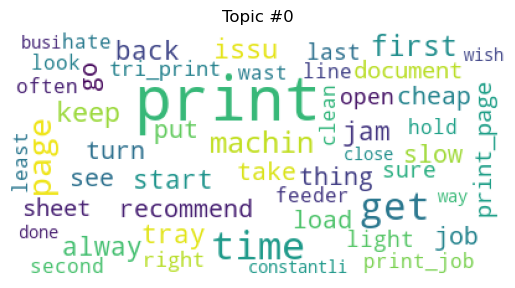

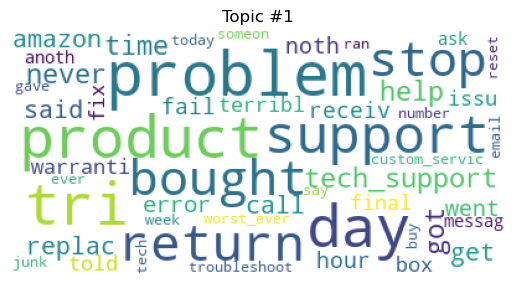

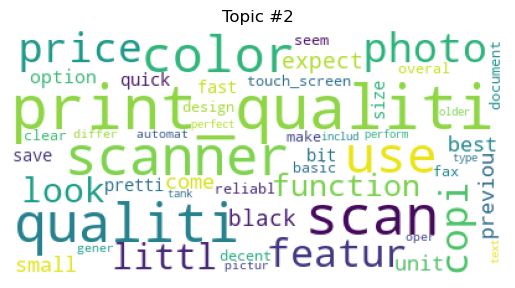

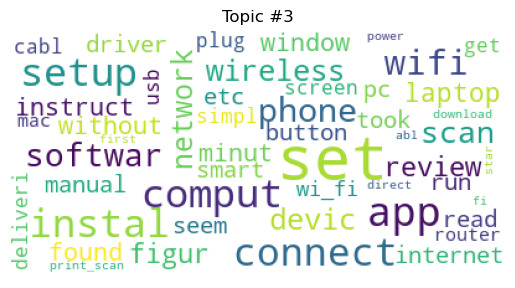

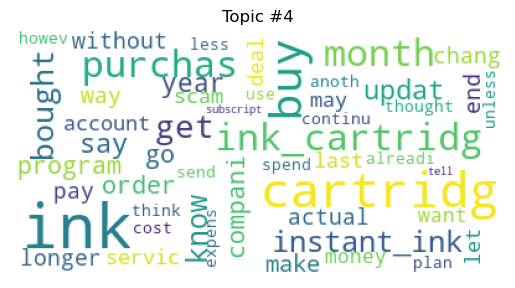

In [323]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(final_model.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(final_model.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [329]:
df_processed["topic_mix"] = final_model.get_document_topics(corpus, minimum_probability=0) 

In [330]:
df_processed["topic_mix"]

0        [(0, 0.19230792), (1, 0.19234435), (2, 0.19230...
1        [(0, 0.21901557), (1, 0.11184421), (2, 0.29345...
2        [(0, 0.2000066), (1, 0.19999284), (2, 0.200005...
3        [(0, 0.16898473), (1, 0.16548108), (2, 0.23930...
4        [(0, 0.26193845), (1, 0.20347576), (2, 0.11856...
                               ...                        
10204    [(0, 0.1851869), (1, 0.1851869), (2, 0.2222203...
10205    [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...
10206    [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...
10207    [(0, 0.20129143), (1, 0.19888622), (2, 0.20103...
10208    [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...
Name: topic_mix, Length: 10209, dtype: object

In [331]:
df_processed[['Topic0','Topic1', 'Topic2', "Topic3", "Topic4"]] = pd.DataFrame(df_processed["topic_mix"].tolist(), 
                                                                      index= df_processed.index)

In [336]:
for i in ['Topic0','Topic1', 'Topic2', "Topic3", "Topic4"]:
    df_processed[i] = df_processed[i].apply(lambda x: x[-1])
df_processed[['Topic0','Topic1', 'Topic2', "Topic3", "Topic4"]] 

Topic0    Topic1    Topic2    Topic3    Topic4
0      0.192308  0.192344  0.192308  0.230732  0.192308
1      0.219016  0.111844  0.293459  0.163706  0.211975
2      0.200007  0.199993  0.200005  0.200003  0.199992
3      0.168985  0.165481  0.239302  0.162820  0.263412
4      0.261938  0.203476  0.118563  0.275790  0.140233
...         ...       ...       ...       ...       ...
10204  0.185187  0.185187  0.222220  0.222219  0.185187
10205  0.200000  0.200000  0.200000  0.200000  0.200000
10206  0.200000  0.200000  0.200000  0.200000  0.200000
10207  0.201291  0.198886  0.201034  0.200546  0.198242
10208  0.200000  0.200000  0.200000  0.200000  0.200000

[10209 rows x 5 columns]

In [338]:
#export LDA results
df_processed[['Topic0','Topic1', 'Topic2', "Topic3", "Topic4", "ID"]].to_csv("LDA\LDA_mix.csv")

<font color=#61BEB0>**Combining the csv:**</font>

In [3]:
lda_mix = pd.read_csv("LDA\LDA_mix.csv")
lda_mix.head()

Unnamed: 0    Topic0    Topic1    Topic2    Topic3    Topic4  ID
0           0  0.192308  0.192344  0.192308  0.230732  0.192308   1
1           1  0.219016  0.111844  0.293459  0.163706  0.211975   2
2           2  0.200007  0.199993  0.200005  0.200003  0.199992   3
3           3  0.168985  0.165481  0.239302  0.162820  0.263412   4
4           4  0.261938  0.203476  0.118563  0.275790  0.140233   5

In [4]:
lda_mix = lda_mix.drop(columns=['Unnamed: 0'])
lda_mix.head()

Topic0    Topic1    Topic2    Topic3    Topic4  ID
0  0.192308  0.192344  0.192308  0.230732  0.192308   1
1  0.219016  0.111844  0.293459  0.163706  0.211975   2
2  0.200007  0.199993  0.200005  0.200003  0.199992   3
3  0.168985  0.165481  0.239302  0.162820  0.263412   4
4  0.261938  0.203476  0.118563  0.275790  0.140233   5

In [5]:
result = pd.merge(df_processed, lda_mix, on='ID', how='left')
result.head()

Review Model Retailer Review date      Review name  \
0     Canon Pixma TS6420a   Amazon  2023-08-10  Ernest Birkholz   
1  HP OfficeJet Pro 9015e   Amazon  2022-06-04           mattey   
2      Canon PIXMA MG3620   Amazon  2023-03-15          Maria D   
3         Epson - ET-3830   Amazon  2022-11-17           Ryan H   
4           HP ENVY 6055e   Amazon  2022-04-09              Sam   

   Review rating       Review title  \
0              5         work great   
1              3    spunki mid size   
2              4                NaN   
3              5  shag know he talk   
4              3      user friendli   

                                      Review Content  \
0                             easi instal work great   
1  slower speed im use old model 8600 new 9015e s...   
2                                                  i   
3  yup slam upgrad paid littl front equival throw...   
4  would think someth simpl reconnect wifi would ...   

   Verified Purchase or not  People_find_helpful  vine or not  ...  Topic0_x  \
0                      True                    0        False  ...  0.192308   
1                      True                    0        False  ...  0.219016   
2                      True                    0        False  ...  0.200007   
3                      True                   12        False  ...  0.168985   
4                      True                    0        False  ...  0.261938   

   Topic1_x  Topic2_x  Topic3_x  Topic4_x  Topic0_y  Topic1_y  Topic2_y  \
0  0.192344  0.192308  0.230732  0.192308  0.192308  0.192344  0.192308   
1  0.111844  0.293459  0.163706  0.211975  0.219016  0.111844  0.293459   
2  0.199993  0.200005  0.200003  0.199992  0.200007  0.199993  0.200005   
3  0.165481  0.239302  0.162820  0.263412  0.168985  0.165481  0.239302   
4  0.203476  0.118563  0.275790  0.140233  0.261938  0.203476  0.118563   

   Topic3_y  Topic4_y  
0  0.230732  0.192308  
1  0.163706  0.211975  
2  0.200003  0.199992  
3  0.162820  0.263412  
4  0.275790  0.140233  

[5 rows x 37 columns]

In [20]:
result.to_excel('amazon_review_processed_full.xlsx', index=False)

<font color=#61BEB0>**Exploring Topics:**</font>

In [3]:
df = pd.read_excel("amazon_review_processed_full.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10209 entries, 0 to 10208
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Review Model              10209 non-null  object        
 1   Retailer                  10209 non-null  object        
 2   Review date               10209 non-null  datetime64[ns]
 3   Review name               10152 non-null  object        
 4   Review rating             10209 non-null  int64         
 5   Review title              10018 non-null  object        
 6   Review Content            10200 non-null  object        
 7   Verified Purchase or not  10209 non-null  bool          
 8   People_find_helpful       10209 non-null  int64         
 9   vine or not               10209 non-null  bool          
 10  URL                       10209 non-null  object        
 11  list price                10209 non-null  float64       
 12  rating count      

In [4]:
#check number of docs with equal probabilities for all topics
test = df.loc[(df["Topic0"] == df["Topic1"]) & (df["Topic1"] == df["Topic2"]) & (df["Topic2"] == df["Topic3"]) &
             (df["Topic3"] == df["Topic4"])]
len(test)

85

In [5]:
df["DomTopic"] = df.iloc[:,[27, 28, 29, 30, 31]].idxmax(axis=1)

In [6]:
df["DomTopic"]

0        Topic3
1        Topic2
2        Topic0
3        Topic4
4        Topic3
          ...  
10204    Topic2
10205    Topic0
10206    Topic0
10207    Topic0
10208    Topic0
Name: DomTopic, Length: 10209, dtype: object

In [14]:
#set default palette
sns.set_palette("Set2")

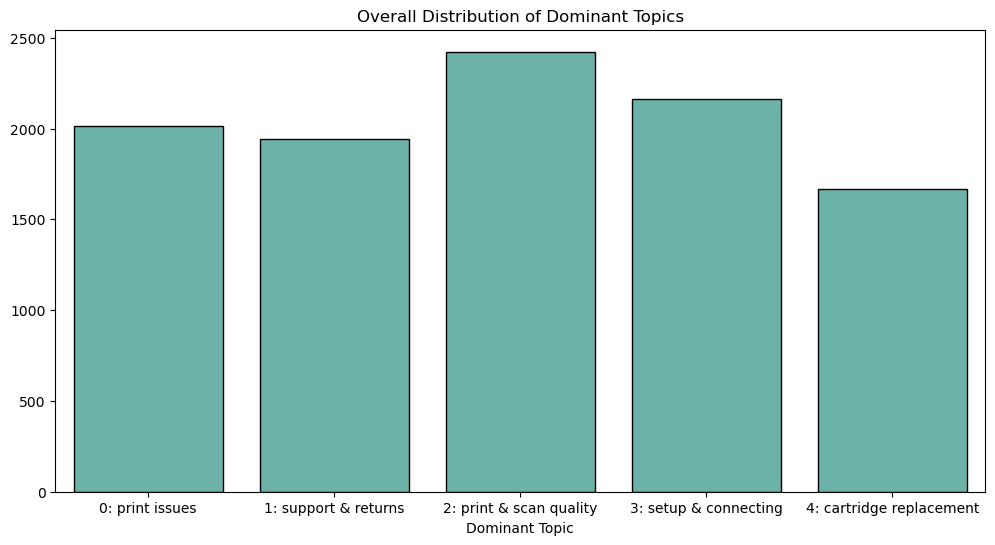

In [59]:
#Overall topic distribution
result = df["DomTopic"].value_counts().sort_index(ascending=True)

plt.figure(figsize=(12, 6))
ax=sns.barplot(x=result.index, y=result.values, color = '#61BEB0', edgecolor = 'black')
ax.set_xticklabels(['0: print issues', '1: support & returns', '2: print & scan quality', 
                    '3: setup & connecting', '4: cartridge replacement'])
ax.set(title='Overall Distribution of Dominant Topics', xlabel='Dominant Topic')
plt.show()

0: print issues
1: support and returns
2: print and scan quality
3: setup and connecting
4: cartridge replacement

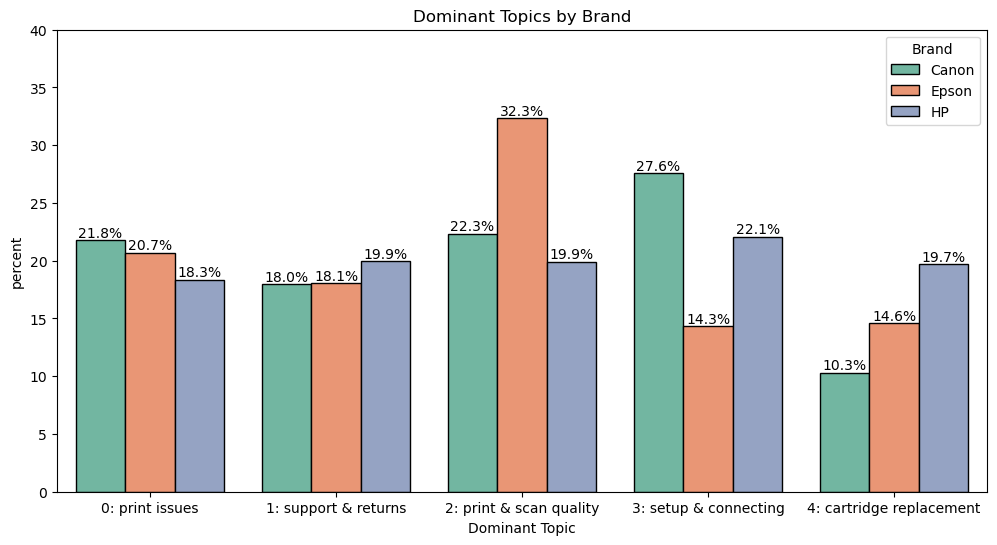

In [62]:
# Plot distribution of topics by brand
rating_pr = df.groupby("Brand")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="DomTopic", y='percent', hue="Brand", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 40)
g.set_xticklabels(['0: print issues', '1: support & returns', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")

# Set the title for the plot
g.set(title='Dominant Topics by Brand', xlabel='Dominant Topic')
plt.show()

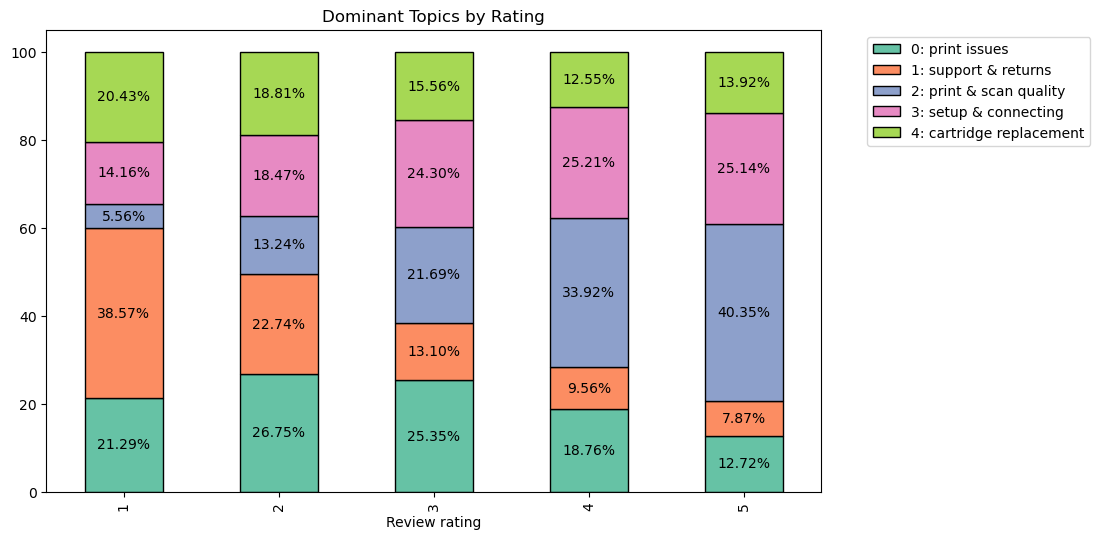

In [63]:
rating_pr = df.groupby("Review rating")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()
table = pd.pivot_table(rating_pr, values="percent", index="Review rating", columns = "DomTopic")

sns.set_palette("Set2")
ax = table.plot(kind='bar', stacked=True, edgecolor = 'black', figsize=(10,6))

ax.set_title('Dominant Topics by Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
           labels=['0: print issues', '1: support & returns', '2: print & scan quality', '3: setup & connecting', 
                   '4: cartridge replacement'])

for c in ax.containers:
    # get the current segment label (a string); corresponds to column / legend
    label = c.get_label()
    
    # create custom labels with the bar height and the percent from the per column
    # the column labels in per and dfp are int, so convert label to int
    labels = ['{text:.2f}%'.format(text=row) if v.get_height() > 0 else '' for v, row in zip(c, table[label])]
    #print(labels)
    
    # add the annotation
    ax.bar_label(c, labels=labels, label_type='center')
    
plt.show()

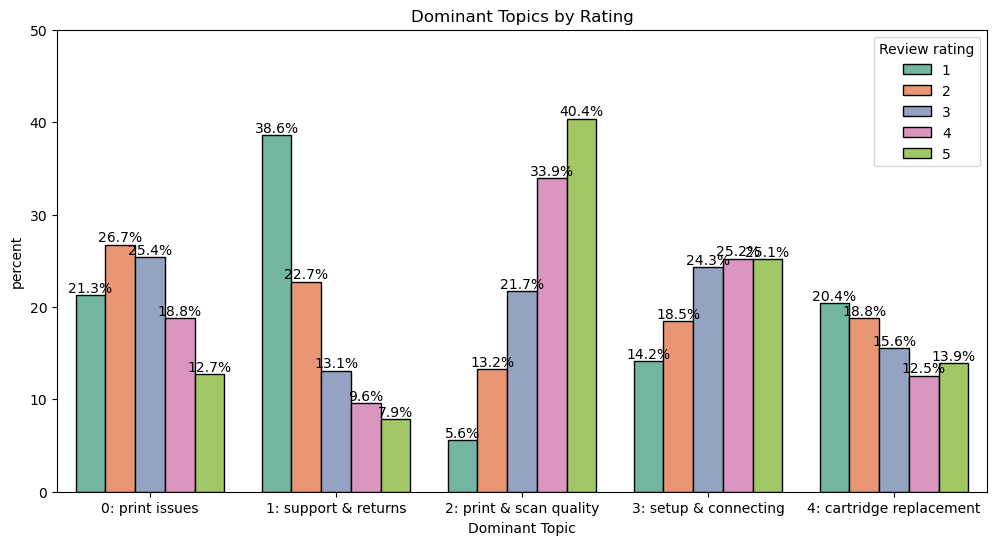

In [64]:
# Plot distribution of topics by rating
rating_pr = df.groupby("Review rating")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="DomTopic", y='percent', hue="Review rating", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 50)

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")
        
g.set_xticklabels(['0: print issues', '1: support & returns', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])

# Set the title for the plot
plt.title('Dominant Topics by Rating')
plt.xlabel('Dominant Topic')
plt.show()

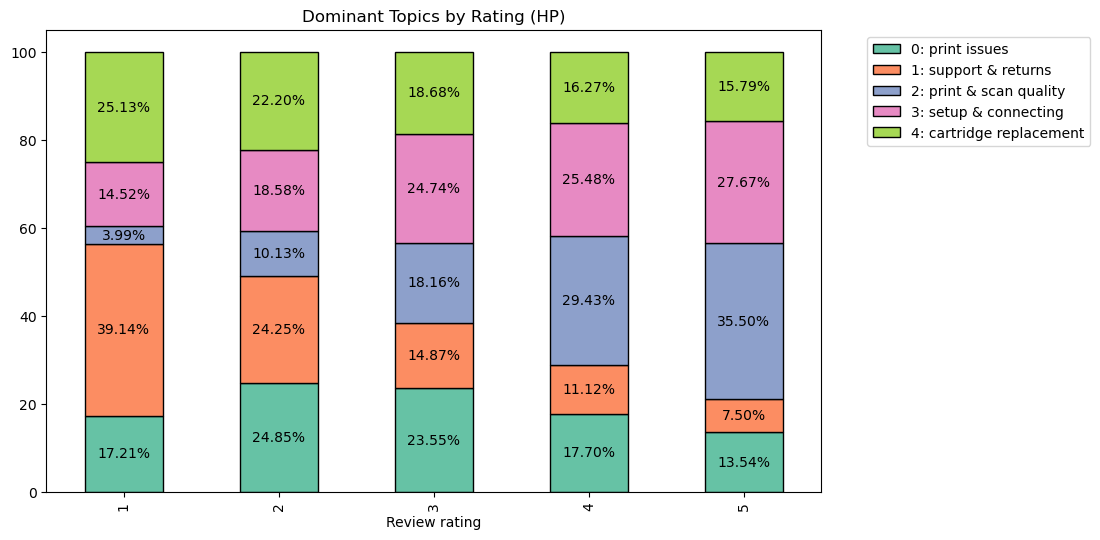

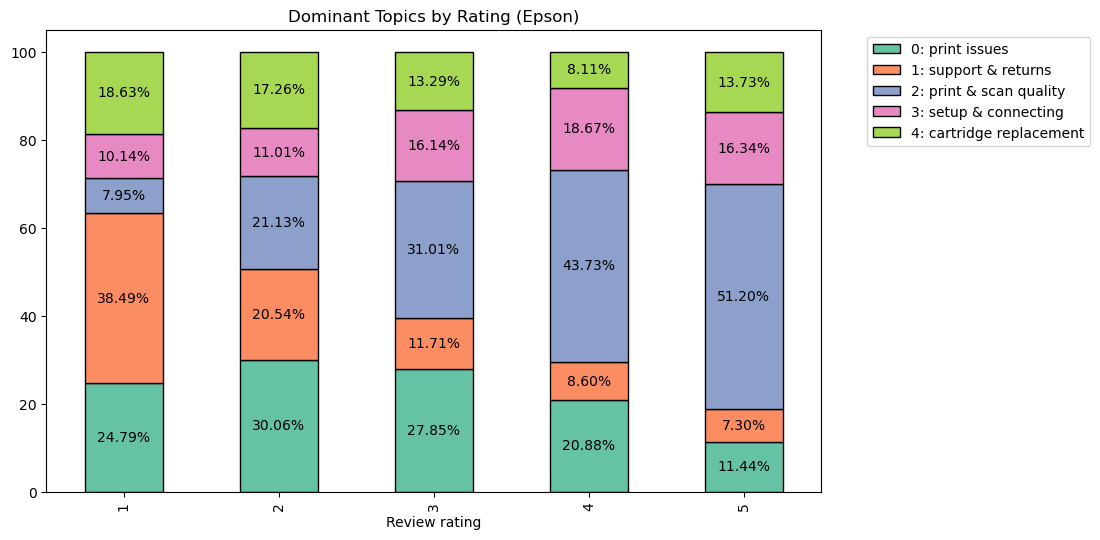

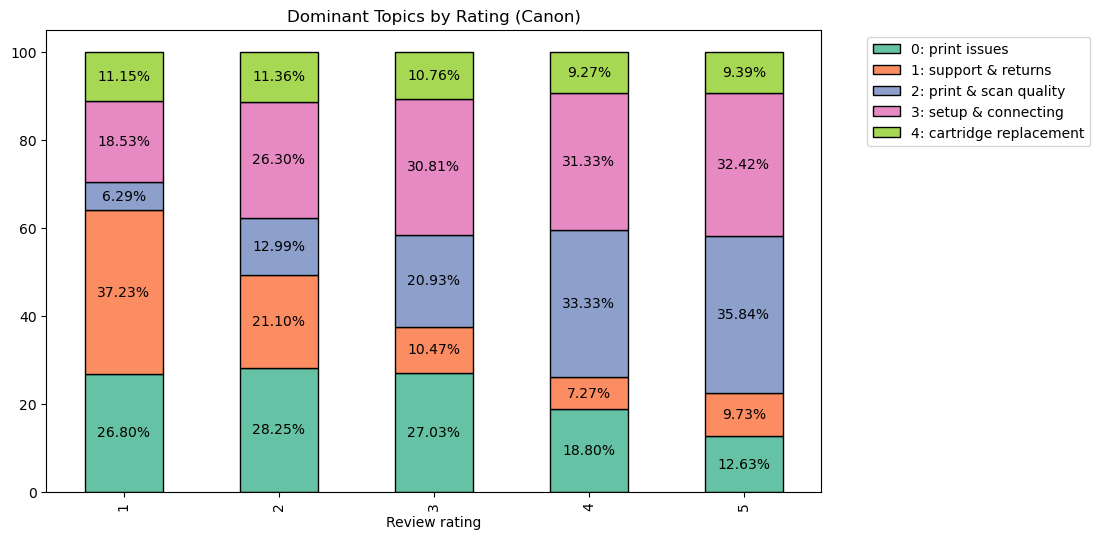

In [75]:
#Dominant topics by brand and rating

for i in ["HP", "Epson", "Canon"]:
    dfbrand = df[df["Brand"]==i]

    rating_pr = dfbrand.groupby("Review rating")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
    rating_pr = rating_pr.mul(100)
    rating_pr = rating_pr.rename('percent').reset_index()
    table = pd.pivot_table(rating_pr, values="percent", index="Review rating", columns = "DomTopic")

    sns.set_palette("Set2")
    ax = table.plot(kind='bar', stacked=True, edgecolor = 'black', figsize=(10,6))

    ax.set_title('Dominant Topics by Rating (' + i + ")")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
               labels=['0: print issues', '1: support & returns', '2: print & scan quality', '3: setup & connecting', 
                       '4: cartridge replacement'])

    for c in ax.containers:
        # get the current segment label (a string); corresponds to column / legend
        label = c.get_label()

        # create custom labels with the bar height and the percent from the per column
        # the column labels in per and dfp are int, so convert label to int
        labels = ['{text:.2f}%'.format(text=row) if v.get_height() > 0 else '' for v, row in zip(c, table[label])]
        #print(labels)

        # add the annotation
        ax.bar_label(c, labels=labels, label_type='center')

    plt.show()

In [20]:
#segment printers by price point
df["pricepoint"] = pd.cut(df["list price"], bins=[0, 100, 250, 1500], labels=["Budget", "Mid-range", "High-end"])
df[["list price","pricepoint"]].head()

list price pricepoint
0      129.99  Mid-range
1      289.99   High-end
2       79.99     Budget
3      399.99   High-end
4      129.99  Mid-range

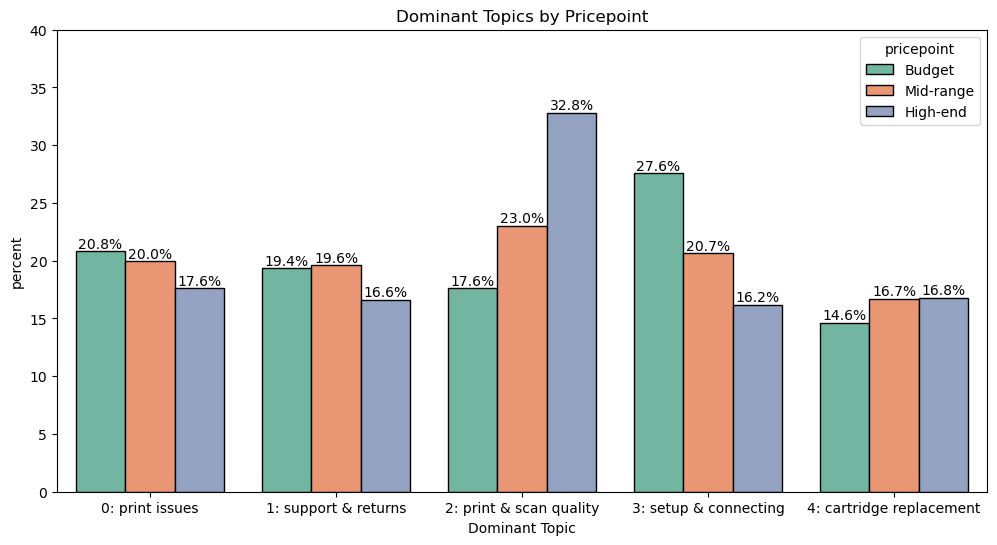

In [21]:
# Plot distribution of topics by price point
rating_pr = df.groupby("pricepoint")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="DomTopic", y='percent', hue="pricepoint", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 40)
g.set_xticklabels(['0: print issues', '1: support & returns', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")

# Set the title for the plot
g.set(title='Dominant Topics by Pricepoint', xlabel='Dominant Topic')
plt.show()

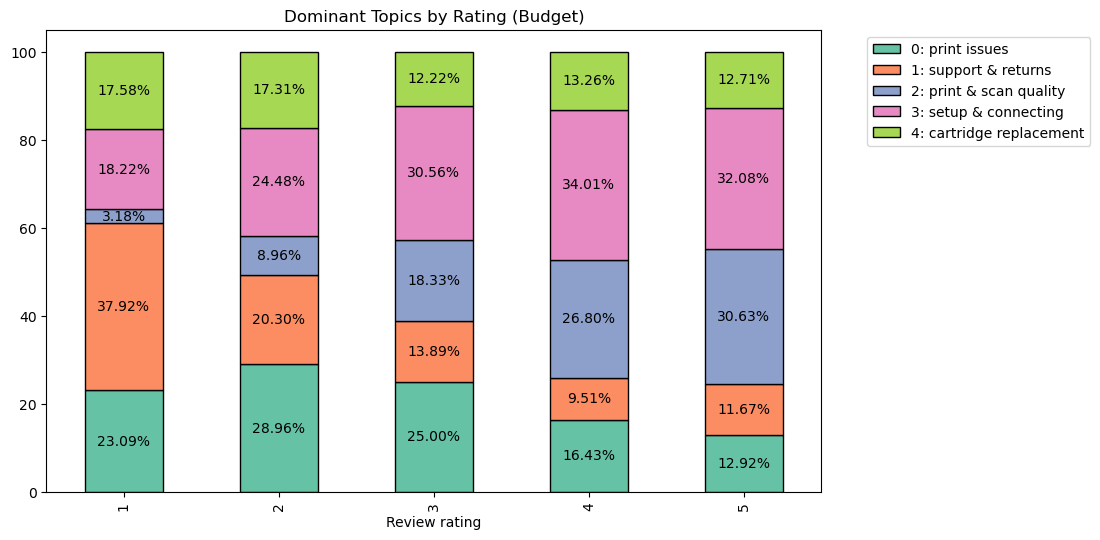

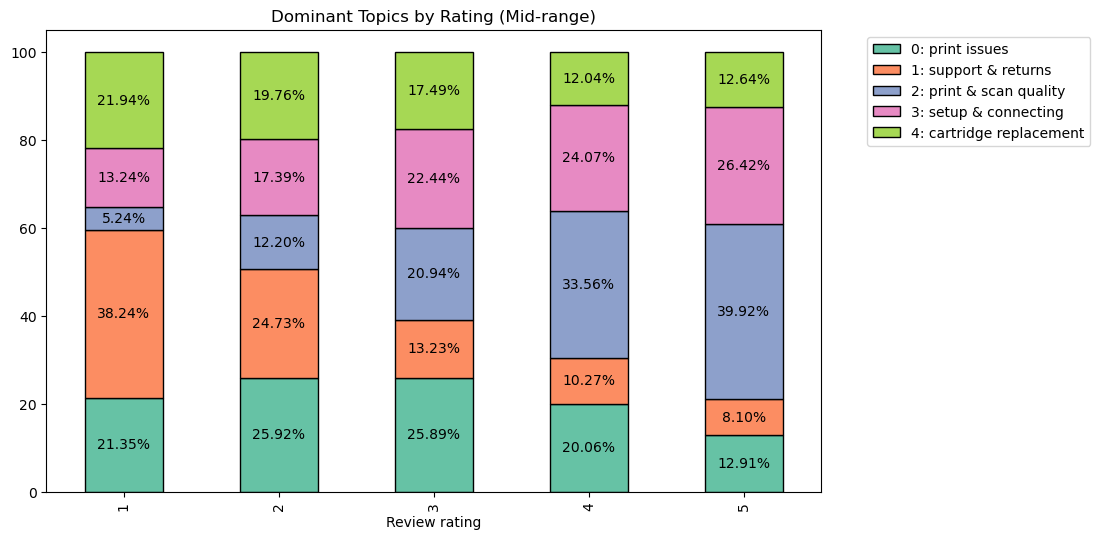

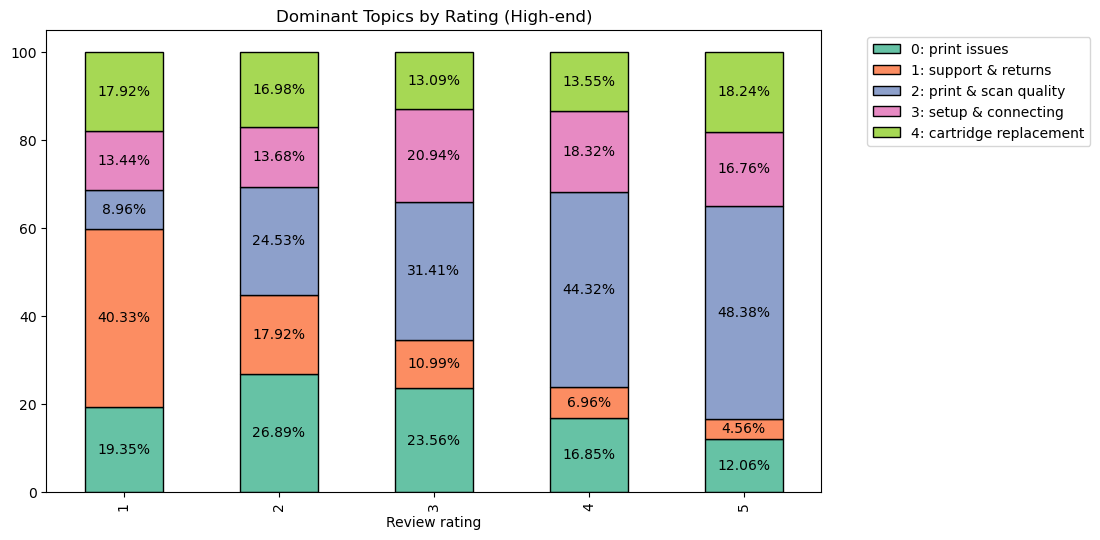

In [81]:
#Dominant topics by price point and rating


for i in ["Budget", "Mid-range", "High-end"]:
    dfbrand = df[df["pricepoint"]==i]

    rating_pr = dfbrand.groupby("Review rating")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
    rating_pr = rating_pr.mul(100)
    rating_pr = rating_pr.rename('percent').reset_index()
    table = pd.pivot_table(rating_pr, values="percent", index="Review rating", columns = "DomTopic")

    sns.set_palette("Set2")
    ax = table.plot(kind='bar', stacked=True, edgecolor = 'black', figsize=(10,6))

    ax.set_title('Dominant Topics by Rating (' + i + ")")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
               labels=['0: print issues', '1: support & returns', '2: print & scan quality', '3: setup & connecting', 
                       '4: cartridge replacement'])

    for c in ax.containers:
        # get the current segment label (a string); corresponds to column / legend
        label = c.get_label()

        # create custom labels with the bar height and the percent from the per column
        # the column labels in per and dfp are int, so convert label to int
        labels = ['{text:.2f}%'.format(text=row) if v.get_height() > 0 else '' for v, row in zip(c, table[label])]
        #print(labels)

        # add the annotation
        ax.bar_label(c, labels=labels, label_type='center')

    plt.show()

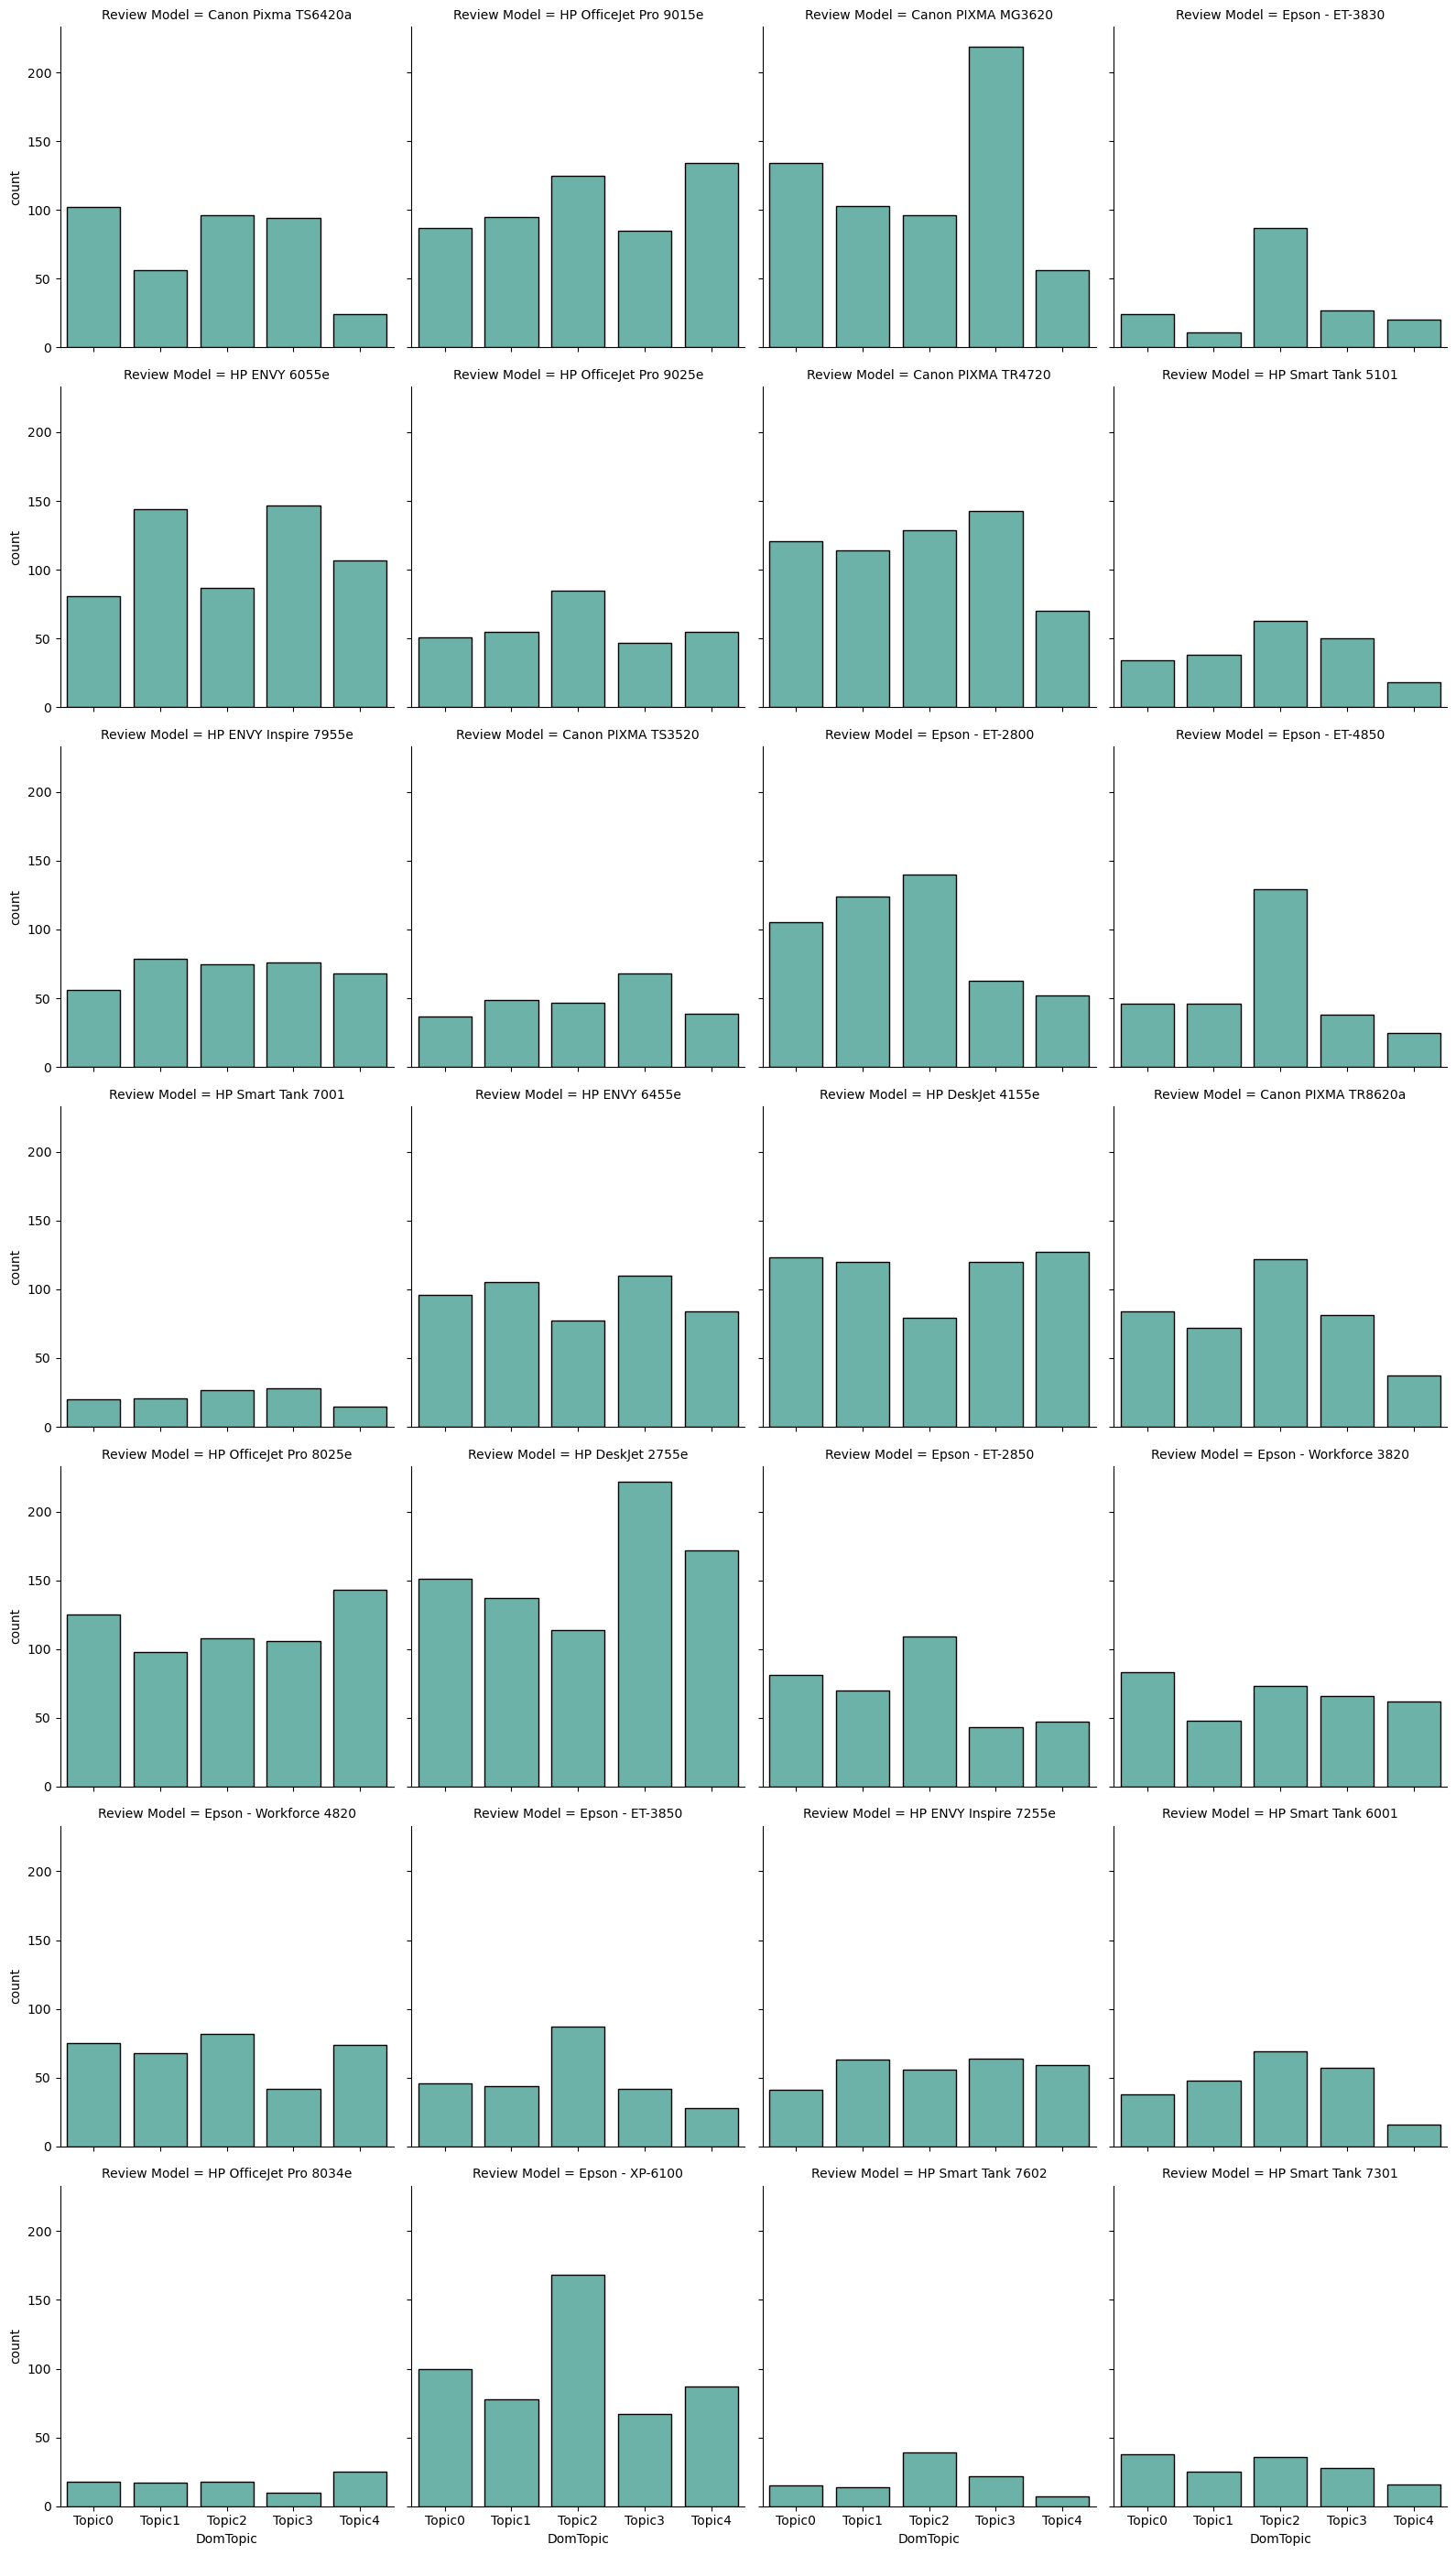

In [70]:
#Dominant topics by model
sns.catplot(
    data=df, x="DomTopic", col="Review Model", kind="count", height=4, col_wrap = 4, color = '#61BEB0', 
    edgecolor = 'black', order=["Topic0", "Topic1", "Topic2", "Topic3", "Topic4"]
)
plt.show()

In [11]:
#function to wrap labels
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

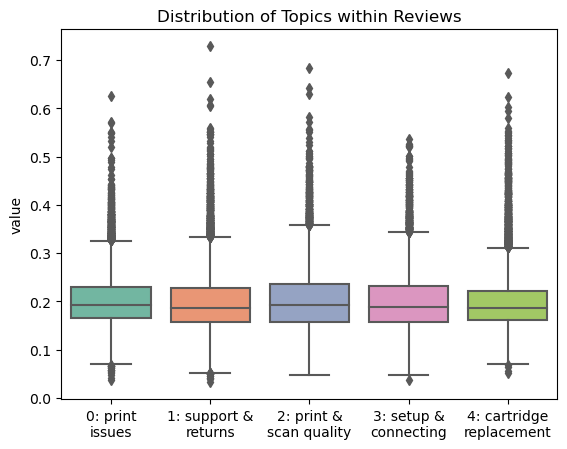

In [65]:
#overall distribution of each topic within each doc
g=sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,[27, 28, 29, 30, 31]]))
g.set_xticklabels(['0: print issues', '1: support & returns', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])
g.set(title='Distribution of Topics within Reviews')

wrap_labels(g, 13)
plt.xlabel('')
plt.xlabel('')
plt.show()

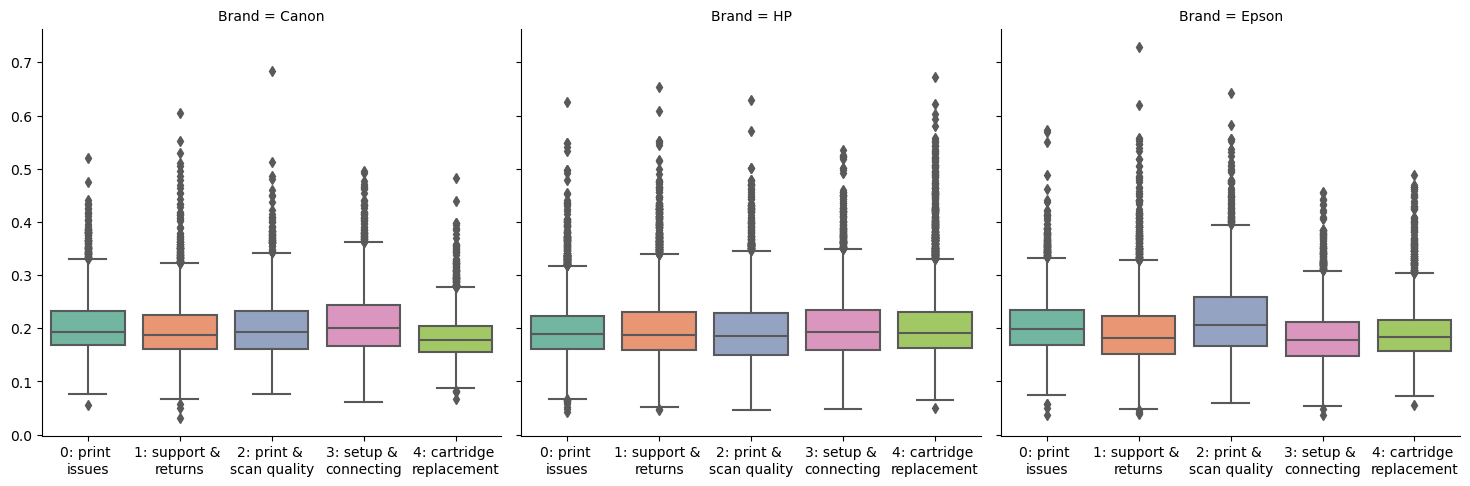

In [68]:
#distribution of each topic within each doc (by brand)
table = pd.melt(df.iloc[:,[24, 27, 28, 29, 30, 31]], id_vars= "Brand",
        value_vars=["Topic0", "Topic1", "Topic2", "Topic3", "Topic4",])

g=sns.catplot(
    table, x="variable", y='value', col='Brand', kind='box', col_wrap=3
)
g.set_axis_labels("", "")
g.set_xticklabels(['0: print \nissues', '1: support & \nreturns', '2: print & \nscan quality', 
                   '3: setup & \nconnecting', '4: cartridge \nreplacement'])

plt.show()

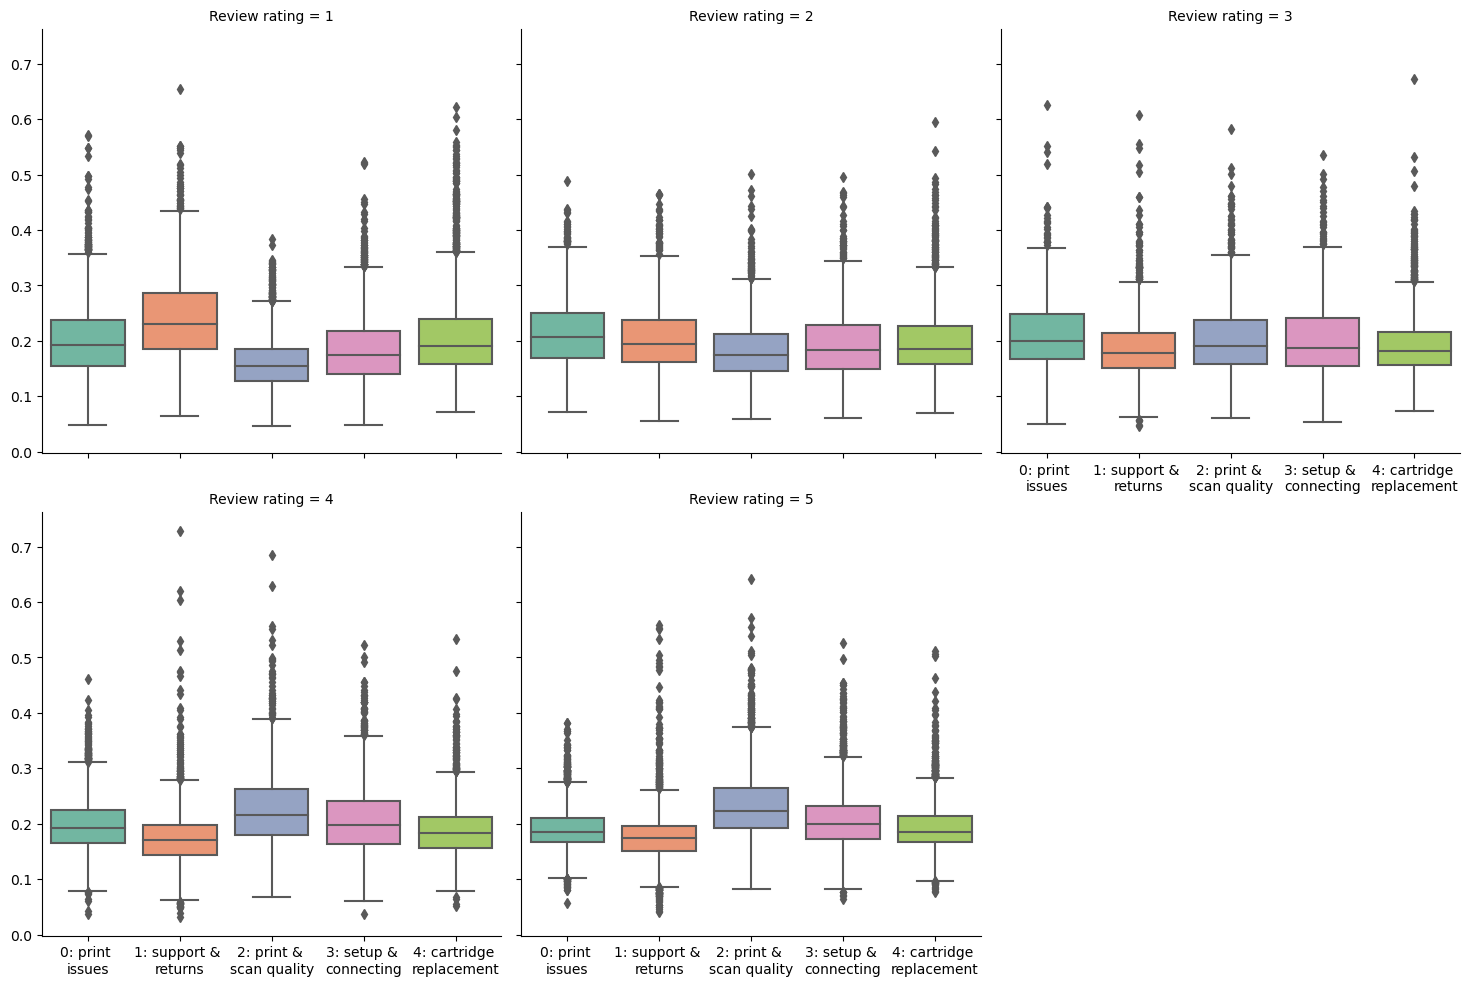

In [69]:
#distribution of each topic within each doc (by rating)
table = pd.melt(df.iloc[:,[4, 27, 28, 29, 30, 31]], id_vars= "Review rating",
        value_vars=["Topic0", "Topic1", "Topic2", "Topic3", "Topic4",])

g=sns.catplot(
    table, x="variable", y='value', col='Review rating', kind='box', col_wrap=3
)
g.set_axis_labels("", "")
g.set_xticklabels(['0: print \nissues', '1: support & \nreturns', '2: print & \nscan quality', 
                   '3: setup & \nconnecting', '4: cartridge \nreplacement'])

plt.show()

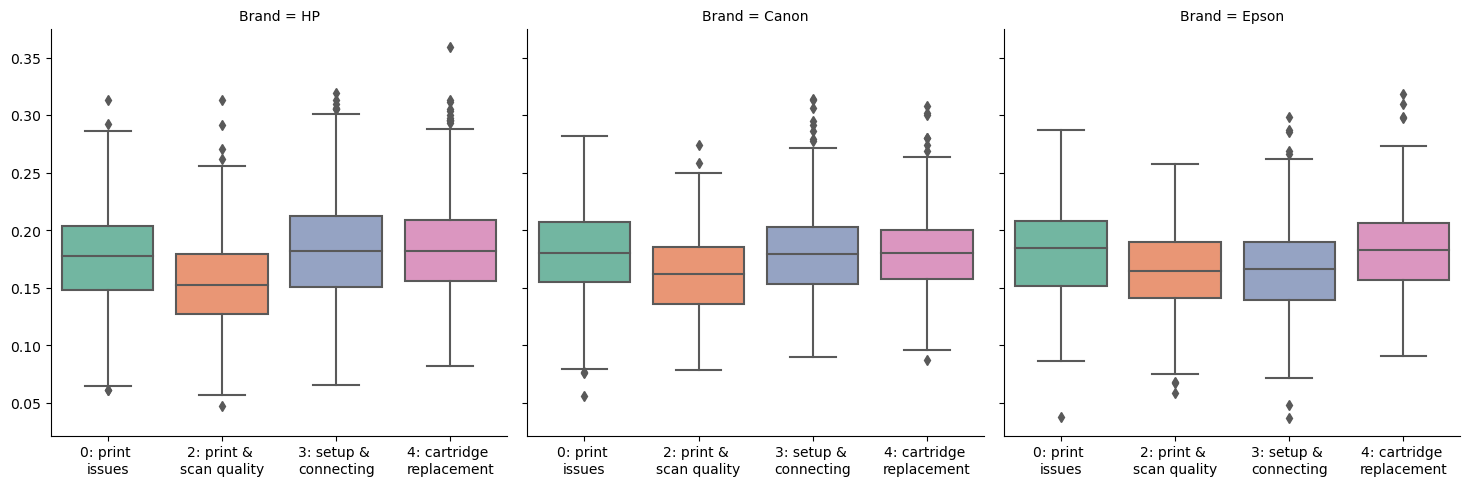

In [15]:
#distribution of each topic within each doc (for dominant topic 1)
dftopic1 = df[df["DomTopic"]=="Topic1"]

table = pd.melt(dftopic1.iloc[:,[24, 27, 29, 30, 31]], id_vars= "Brand",
        value_vars=["Topic0", "Topic2", "Topic3", "Topic4",])

g=sns.catplot(
    table, x="variable", y='value', col='Brand', kind='box', col_wrap=3
)
g.set_axis_labels("", "")
g.set_xticklabels(['0: print \nissues', '2: print & \nscan quality', 
                   '3: setup & \nconnecting', '4: cartridge \nreplacement'])

#Topics closely related to topic 1
dftopic1 = df[df["DomTopic"]=="Topic1"]plt.show()

In [17]:
#Topics closely related to topic 1
dftopic1 = df[df["DomTopic"]=="Topic1"]

dftopic1['DomTopic2'] = dftopic1.iloc[:,[27, 29, 30, 31]].idxmax(axis=1)
dftopic1['DomTopic2']

C:\Users\bluec\AppData\Local\Temp\ipykernel_9048\2387670913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftopic1['DomTopic2'] = dftopic1.iloc[:,[27, 29, 30, 31]].idxmax(axis=1)


6        Topic4
7        Topic0
14       Topic3
15       Topic4
17       Topic0
          ...  
10189    Topic3
10195    Topic3
10197    Topic4
10199    Topic4
10201    Topic4
Name: DomTopic2, Length: 1942, dtype: object

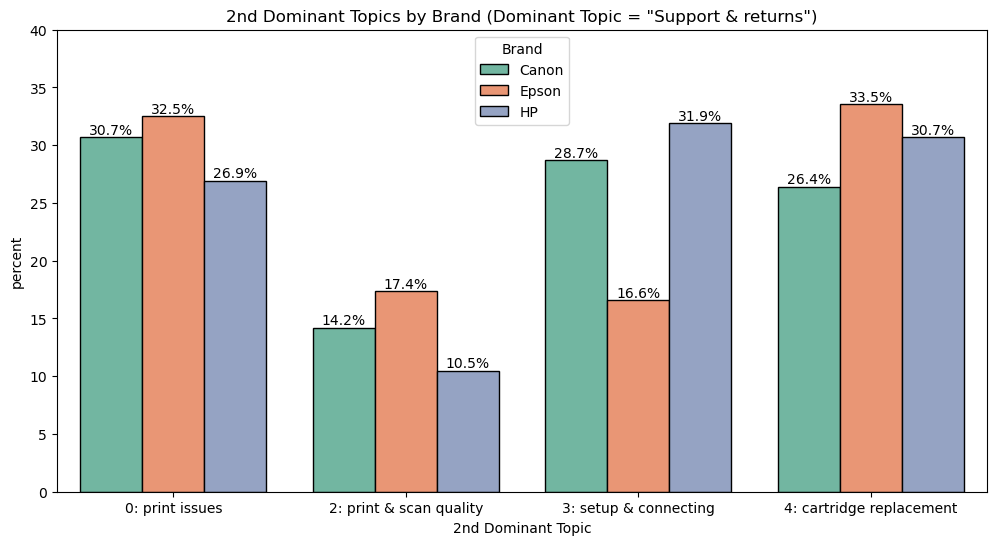

In [19]:
# Plot distribution of topics by brand for all reviews with dominant topic ==1
rating_pr = dftopic1.groupby("Brand")["DomTopic2"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="DomTopic2", y='percent', hue="Brand", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 40)
g.set_xticklabels(['0: print issues', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")

# Set the title for the plot
g.set(title='2nd Dominant Topics by Brand (Dominant Topic = "Support & returns")', xlabel='2nd Dominant Topic')
plt.show()

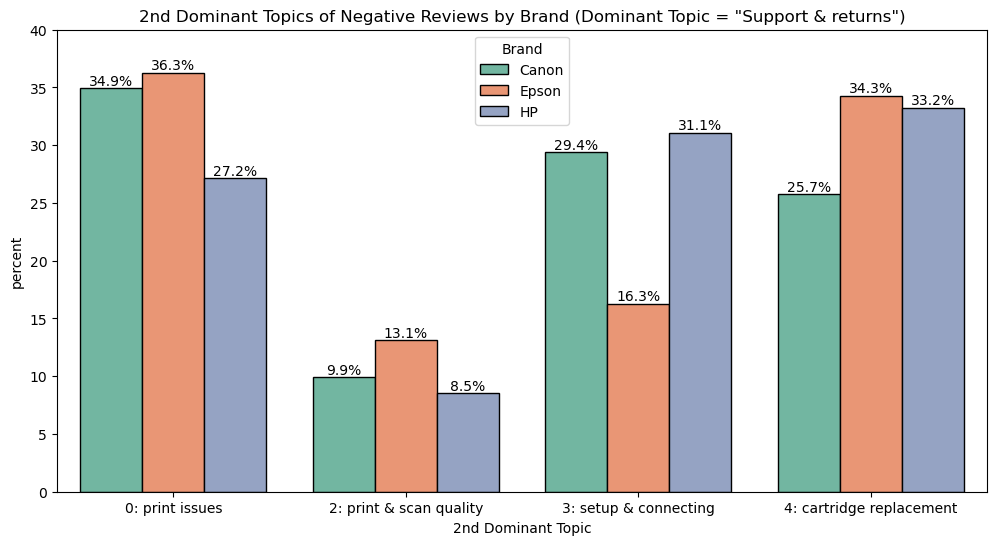

In [23]:
# Plot distribution of topics by brand for negative reviews with dominant topic ==1
dftopic1neg = dftopic1[(dftopic1["Review rating"] ==1) | (dftopic1["Review rating"] ==2)]

rating_pr = dftopic1neg.groupby("Brand")["DomTopic2"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="DomTopic2", y='percent', hue="Brand", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 40)
g.set_xticklabels(['0: print issues', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")

# Set the title for the plot
g.set(title='2nd Dominant Topics of Negative Reviews by Brand (Dominant Topic = "Support & returns")', xlabel='2nd Dominant Topic')
plt.show()

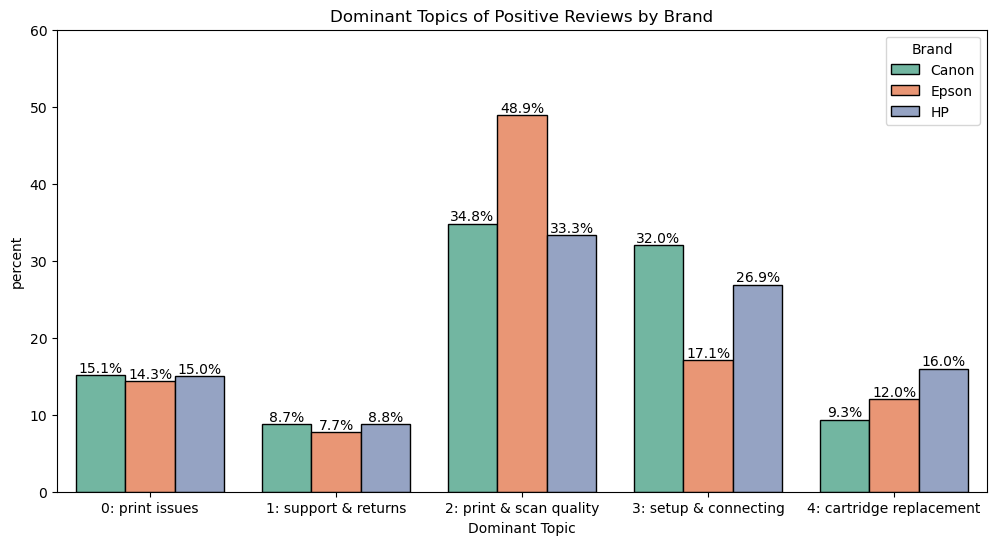

In [28]:
# Plot distribution of topics for positive reviews by brand
dfpos = df[(df["Review rating"] ==4) | (df["Review rating"] ==5)]

rating_pr = dfpos.groupby("Brand")["DomTopic"].value_counts(normalize=True).sort_index(ascending=True)
rating_pr = rating_pr.mul(100)
rating_pr = rating_pr.rename('percent').reset_index()

plt.figure(figsize=(12, 6))
g = sns.barplot(x="DomTopic", y='percent', hue="Brand", edgecolor = 'black', data=rating_pr, palette="Set2")
g.set_ylim(0, 60)
g.set_xticklabels(['0: print issues', '1: support & returns', '2: print & scan quality', 
                   '3: setup & connecting', '4: cartridge replacement'])

# Loop through the bars and add percentage labels
for p in g.patches:
    height = p.get_height()  # Get the height of the bar
    if height >= 1.0:  # Only label bars with percentages >= 1%
        txt = str(round(float(height), 1)) + '%'  # Convert to float and round to 1 decimal place
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = height
        g.text(txt_x, txt_y, txt, ha="center", va="bottom")

# Set the title for the plot
g.set(title='Dominant Topics of Positive Reviews by Brand', xlabel='Dominant Topic')
plt.show()